# Bankruptcy Prevention Analysis
This project predicts company bankruptcy risk using key financial and operational factors through machine learning classification models.
## Problem Description
- Binary classification task to predict company bankruptcy
- Dataset contains 7 features for 250 companies
- Features include various risk factors and company characteristics
- Target variable: bankruptcy vs non-bankruptcy

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# For preprocessing and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,  f1_score, precision_score, recall_score
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
import lightgbm as lgb
import xgboost as xgb

# For visualizations
import plotly.express as px
import plotly.graph_objects as go

# For reading Excel files
import openpyxl

import warnings
warnings.filterwarnings("ignore")
import sys, os

import joblib
import pickle
import time
from sklearn.pipeline import Pipeline



# Settings
plt.style.use('default')  # Using default matplotlib style
sns.set_theme()  # Set the default seaborn theme
%matplotlib inline

## Data Loading and Initial Exploration

In [2]:
# --- Read data from Excel file ---
df = pd.read_excel('Bankruptcy.xlsx')

# --- Ensure column names are correctly formatted ---
df.columns = df.columns.str.strip().str.lower()  # lowercase and remove whitespace

# ---  Data validation and cleaning ---

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check data types
print("\nData Types:")
print(df.dtypes)

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Optionally remove duplicates
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"After removing duplicates, dataset shape: {df.shape}")

# Display basic information about the dataset
print("\nDataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nFirst few rows:")
display(df.head())

# --- Descriptive statistics for numeric features only ---
print("\nDescriptive Statistics (Numeric Features):")
display(df.select_dtypes(include='number').describe())

# --- Class distribution (if target column exists) ---
if 'class' in df.columns:
    print("\nClass Distribution:")
    print(df['class'].value_counts(normalize=True) * 100)  # show percentages

# --- Optional: basic relationships without correlation ---
numeric_cols = df.select_dtypes(include='number').columns.tolist()
if len(numeric_cols) > 1:
    print("\nPairwise Summary (Mean, Min, Max) for Numeric Features:")
    pairwise_summary = df[numeric_cols].agg(['mean', 'min', 'max'])
    display(pairwise_summary)


Missing Values:
industrial_risk          0
management_risk          0
financial_flexibility    0
credibility              0
competitiveness          0
operating_risk           0
class                    0
dtype: int64

Data Types:
industrial_risk          float64
management_risk          float64
financial_flexibility    float64
credibility              float64
competitiveness          float64
operating_risk           float64
class                     object
dtype: object

Number of duplicate rows: 147
After removing duplicates, dataset shape: (103, 7)

Dataset Shape: (103, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 0 to 194
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        103 non-null    float64
 1   management_risk        103 non-null    float64
 2   financial_flexibility  103 non-null    float64
 3   credibility            103 non-null   

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
0,0.5,1.0,0.0,0.0,0.0,0.5,bankruptcy
1,0.0,1.0,0.0,0.0,0.0,1.0,bankruptcy
2,1.0,0.0,0.0,0.0,0.0,1.0,bankruptcy
3,0.5,0.0,0.0,0.5,0.0,1.0,bankruptcy
4,1.0,1.0,0.0,0.0,0.0,1.0,bankruptcy



Descriptive Statistics (Numeric Features):


,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,0.485437,0.563107,0.504854,0.582524,0.640777,0.514563
std,0.404971,0.412308,0.405206,0.377668,0.410747,0.439788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000
50%,0.500000,0.500000,0.500000,0.500000,1.000000,0.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Class Distribution:
class
non-bankruptcy    75.728155
bankruptcy        24.271845
Name: proportion, dtype: float64

Pairwise Summary (Mean, Min, Max) for Numeric Features:


,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk
mean,0.485437,0.563107,0.504854,0.582524,0.640777,0.514563
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploratory Data Analysis (EDA)
Performed exploratory data analysis to understand feature distributions, relationships, and key patterns affecting bankruptcy risk.

### Count Plots – Distribution Analysis 
Shows the frequency of each category for all features and class balance, highlighting differences between bankruptcy and non-bankruptcy cases.

Analyzed feature distributions and class balance — 57.2% non-bankruptcy and 42.8% bankruptcy — indicating a moderately balanced dataset suitable for classification.

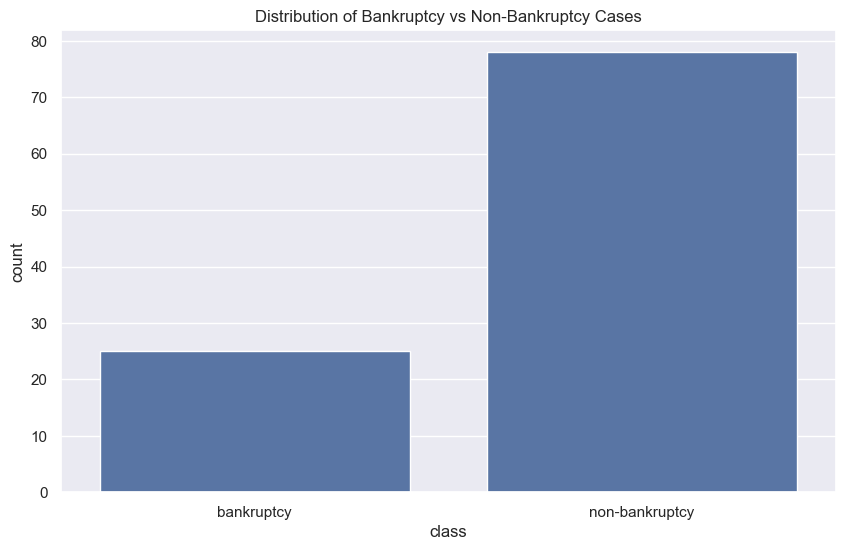


Class Distribution (%):
 class
non-bankruptcy    75.728155
bankruptcy        24.271845
Name: proportion, dtype: float64


In [3]:
# Check class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='class')
plt.title('Distribution of Bankruptcy vs Non-Bankruptcy Cases')
plt.show()

# Calculate class percentages
class_dist = df['class'].value_counts(normalize=True) * 100
print("\nClass Distribution (%):\n", class_dist)

### Histogram: Feature Distribution

Shows the frequency distribution of feature values for bankruptcy and non-bankruptcy cases.

Distinct patterns indicate strong predictive potential, while overlapping values may still contribute when combined with other features.

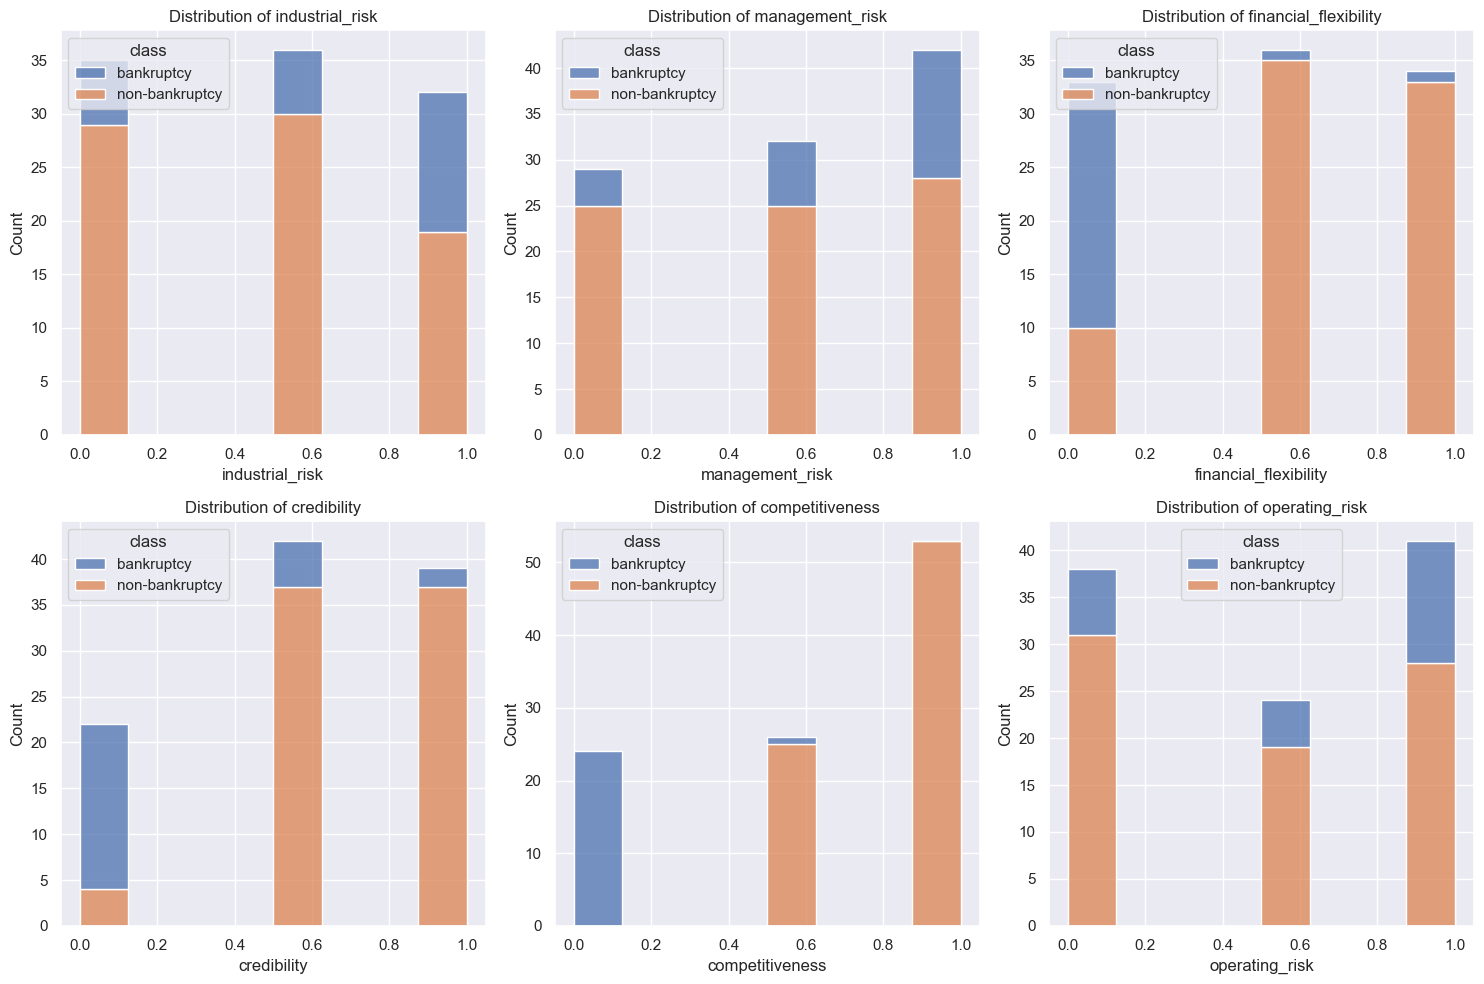

In [4]:
# Create histograms for each feature
plt.figure(figsize=(15, 10))
features = df.columns[:-1]  # All columns except 'class'

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=feature, hue='class', multiple="stack")
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Boxplot: Feature Spread by Class

Displays the range, median, and variability of each feature for the two classes. 

Features with clear differences between classes suggest high discriminative power, while overlapping features may be less individually predictive.

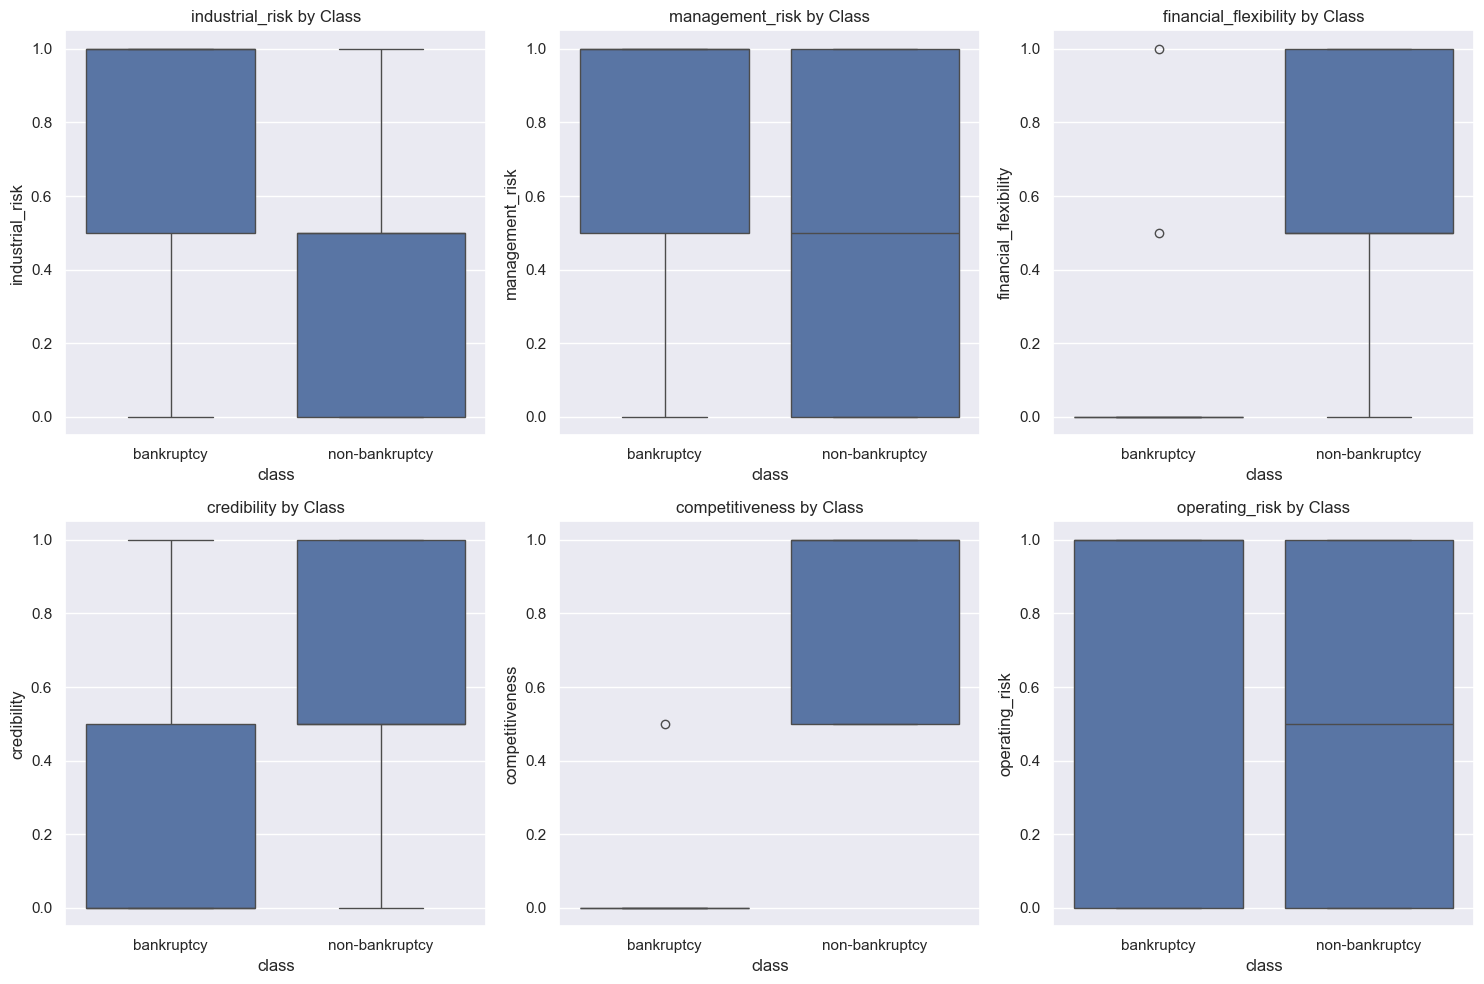

In [5]:
# Feature distributions
fig = plt.figure(figsize=(15, 10))
features = df.columns[:-1]  # All columns except 'class'

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, y=feature, x='class')
    plt.title(f'{feature} by Class')

plt.tight_layout()
plt.show()

### Correlation Analysis

Analyzes relationships between features and their correlation with bankruptcy risk. 

Features like competitiveness, credibility, and financial flexibility are strongly negatively correlated with bankruptcy, while management risk, operating risk, and industrial risk are positively correlated, highlighting key predictors.

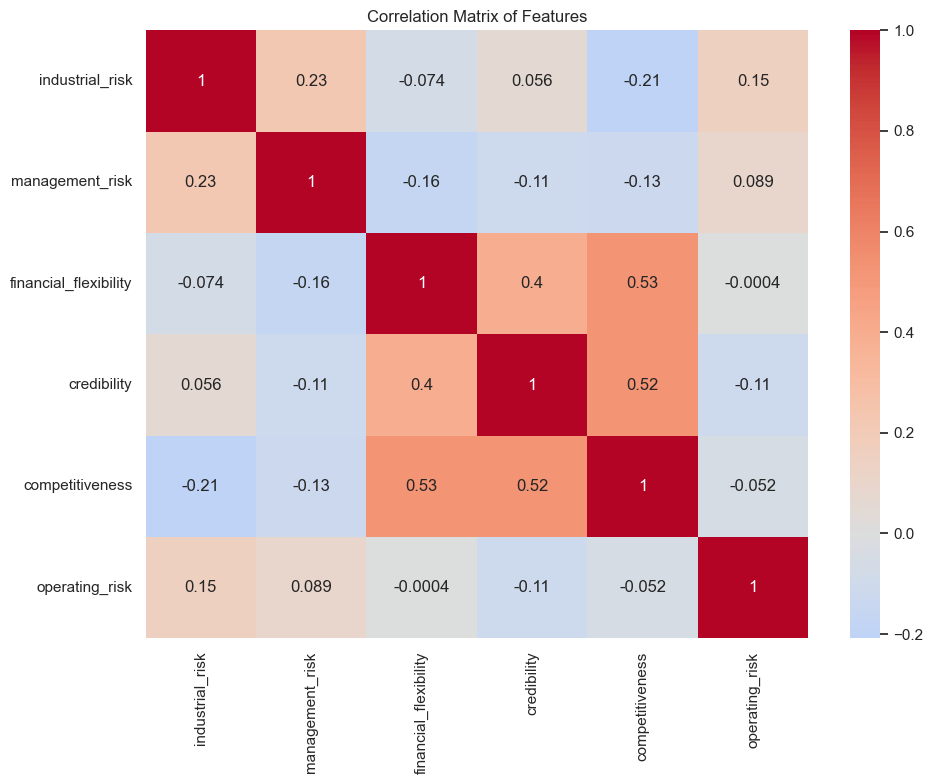


Correlations with Bankruptcy Risk:
industrial_risk          0.217132
management_risk          0.188887
operating_risk           0.136393
credibility             -0.606350
financial_flexibility   -0.624573
competitiveness         -0.859809
dtype: float64


In [6]:
# Calculate correlations excluding the categorical 'class' column
features_only = df.drop('class', axis=1)

# Correlation matrix for features
plt.figure(figsize=(10, 8))
correlation_matrix = features_only.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

# Calculate correlations with target variable
# First create binary target (1 for bankruptcy, 0 for non-bankruptcy)
target = (df['class'] == 'bankruptcy').astype(int)

# Calculate correlation with target
correlations_with_target = features_only.apply(lambda x: x.corr(target))
print("\nCorrelations with Bankruptcy Risk:")
print(correlations_with_target.sort_values(ascending=False))

### Pairplots & Clustered Heatmap 

The pairplot visualizes pairwise relationships and class separation between features.

The Clustered Heatmap groups correlated features, highlighting patterns and feature clusters that may influence bankruptcy prediction.

<Figure size 1200x800 with 0 Axes>

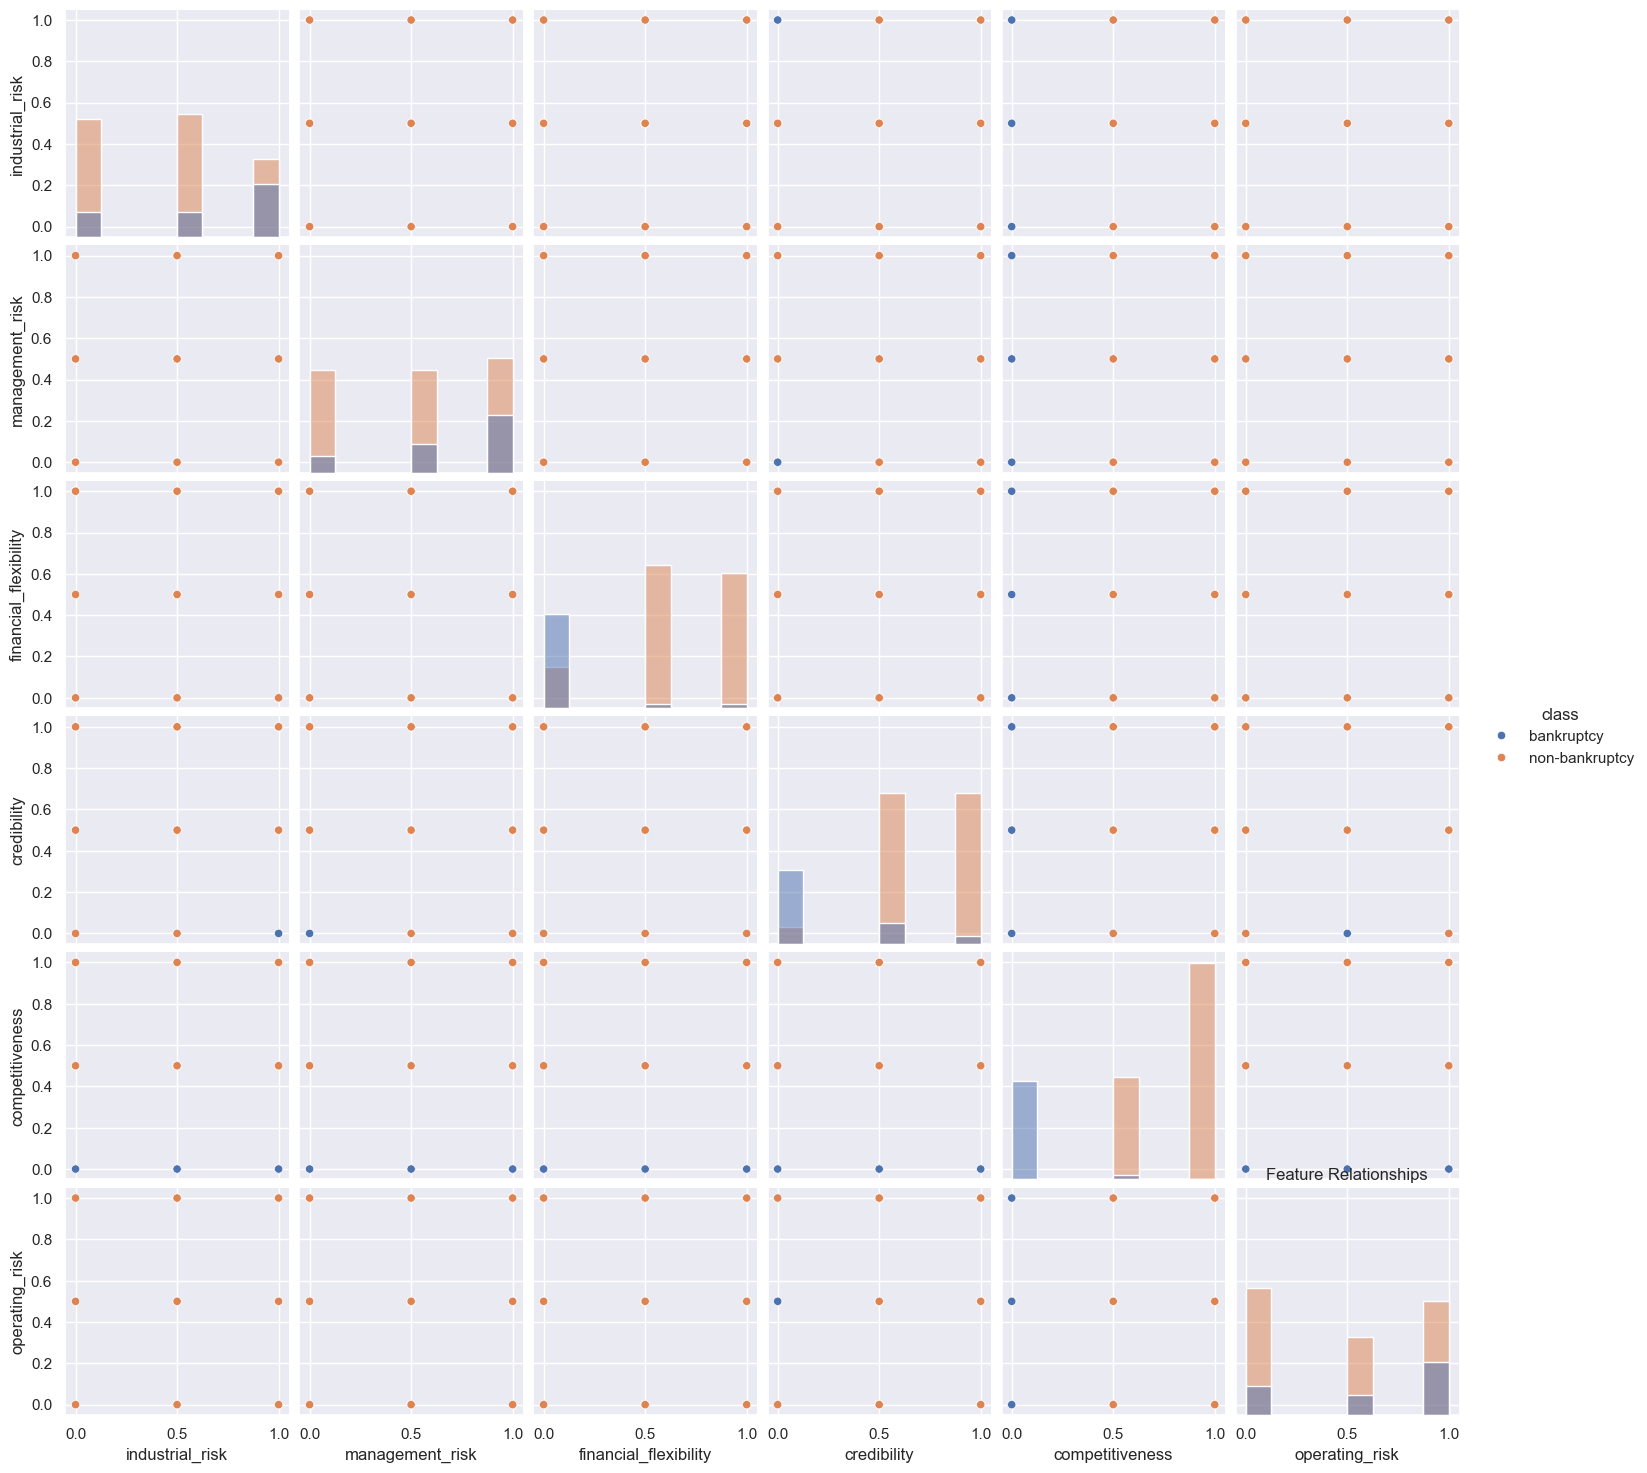

<Figure size 1200x1000 with 0 Axes>

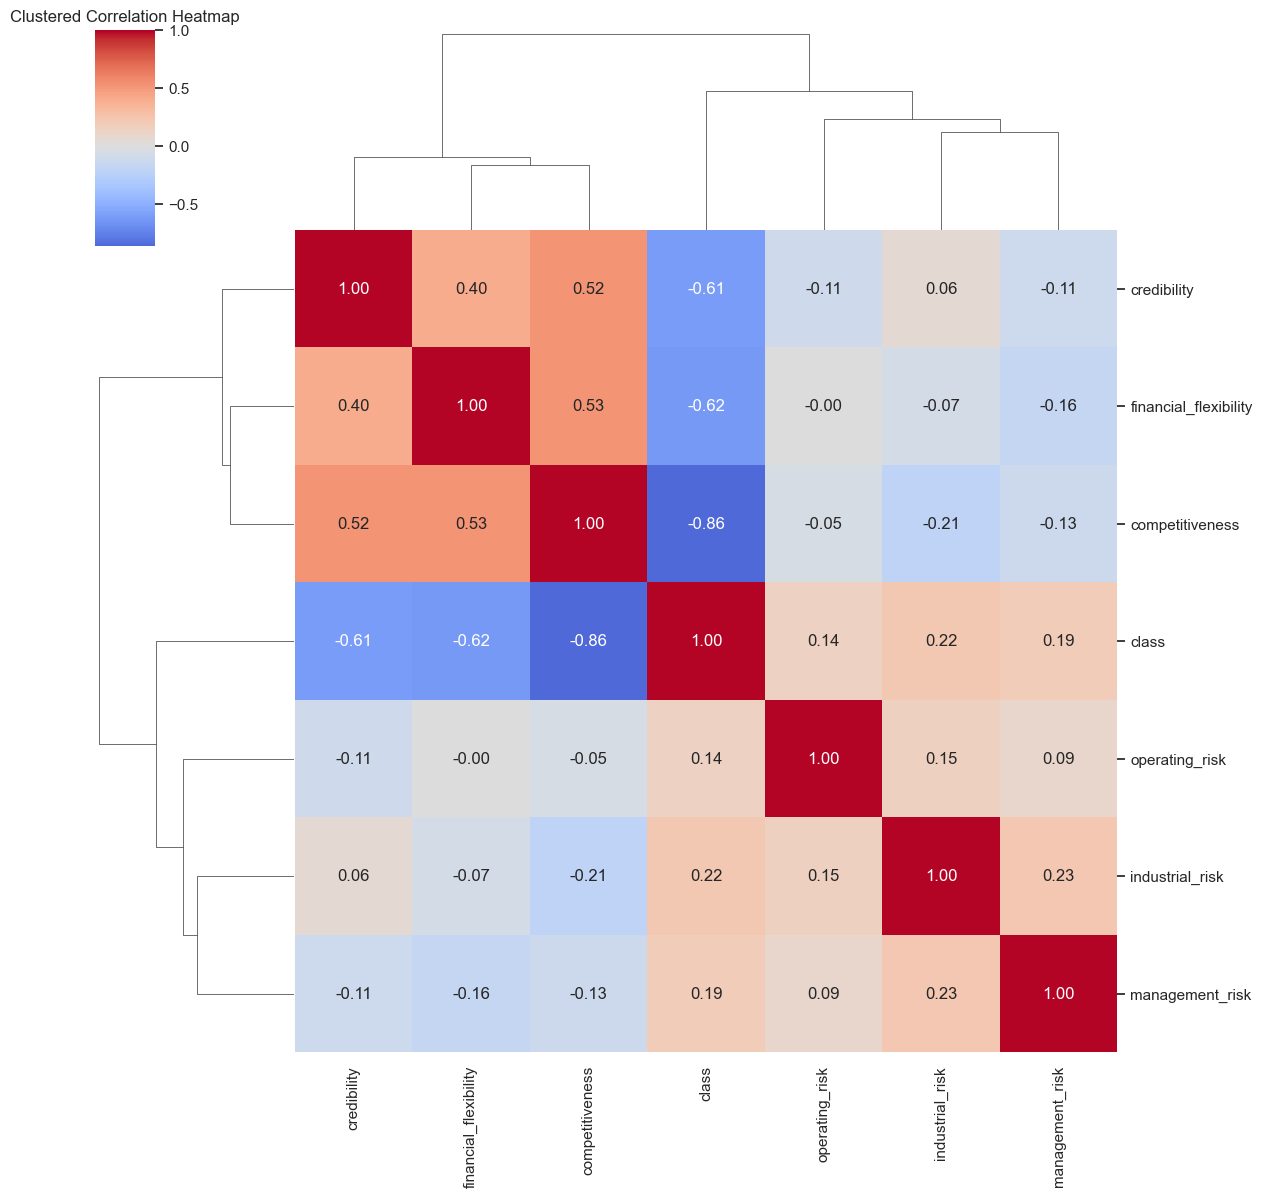

In [7]:
# Create pairplot to show relationships between features
plt.figure(figsize=(12, 8))
sns.pairplot(data=df, hue='class', diag_kind='hist')
plt.title('Feature Relationships')
plt.show()

# Create correlation heatmap with dendrograms
plt.figure(figsize=(12, 10))
# Convert class to numeric for correlation
df_numeric = df.copy()
df_numeric['class'] = (df_numeric['class'] == 'bankruptcy').astype(int)

# Calculate correlation matrix
correlation_matrix = df_numeric.corr()

# Create clustered heatmap
sns.clustermap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    figsize=(12, 12)
)
plt.title('Clustered Correlation Heatmap')
plt.show()

### KDE Plots – Feature Distributions

KDE (Kernel Density Estimation) plots show the probability density of each feature by bankruptcy status, highlighting differences in distributions between classes.

Key insights: Financial Flexibility and Credibility show clear separation, Management and Operating Risks reveal density patterns, while Industrial Risk overlaps, indicating weaker predictive power.

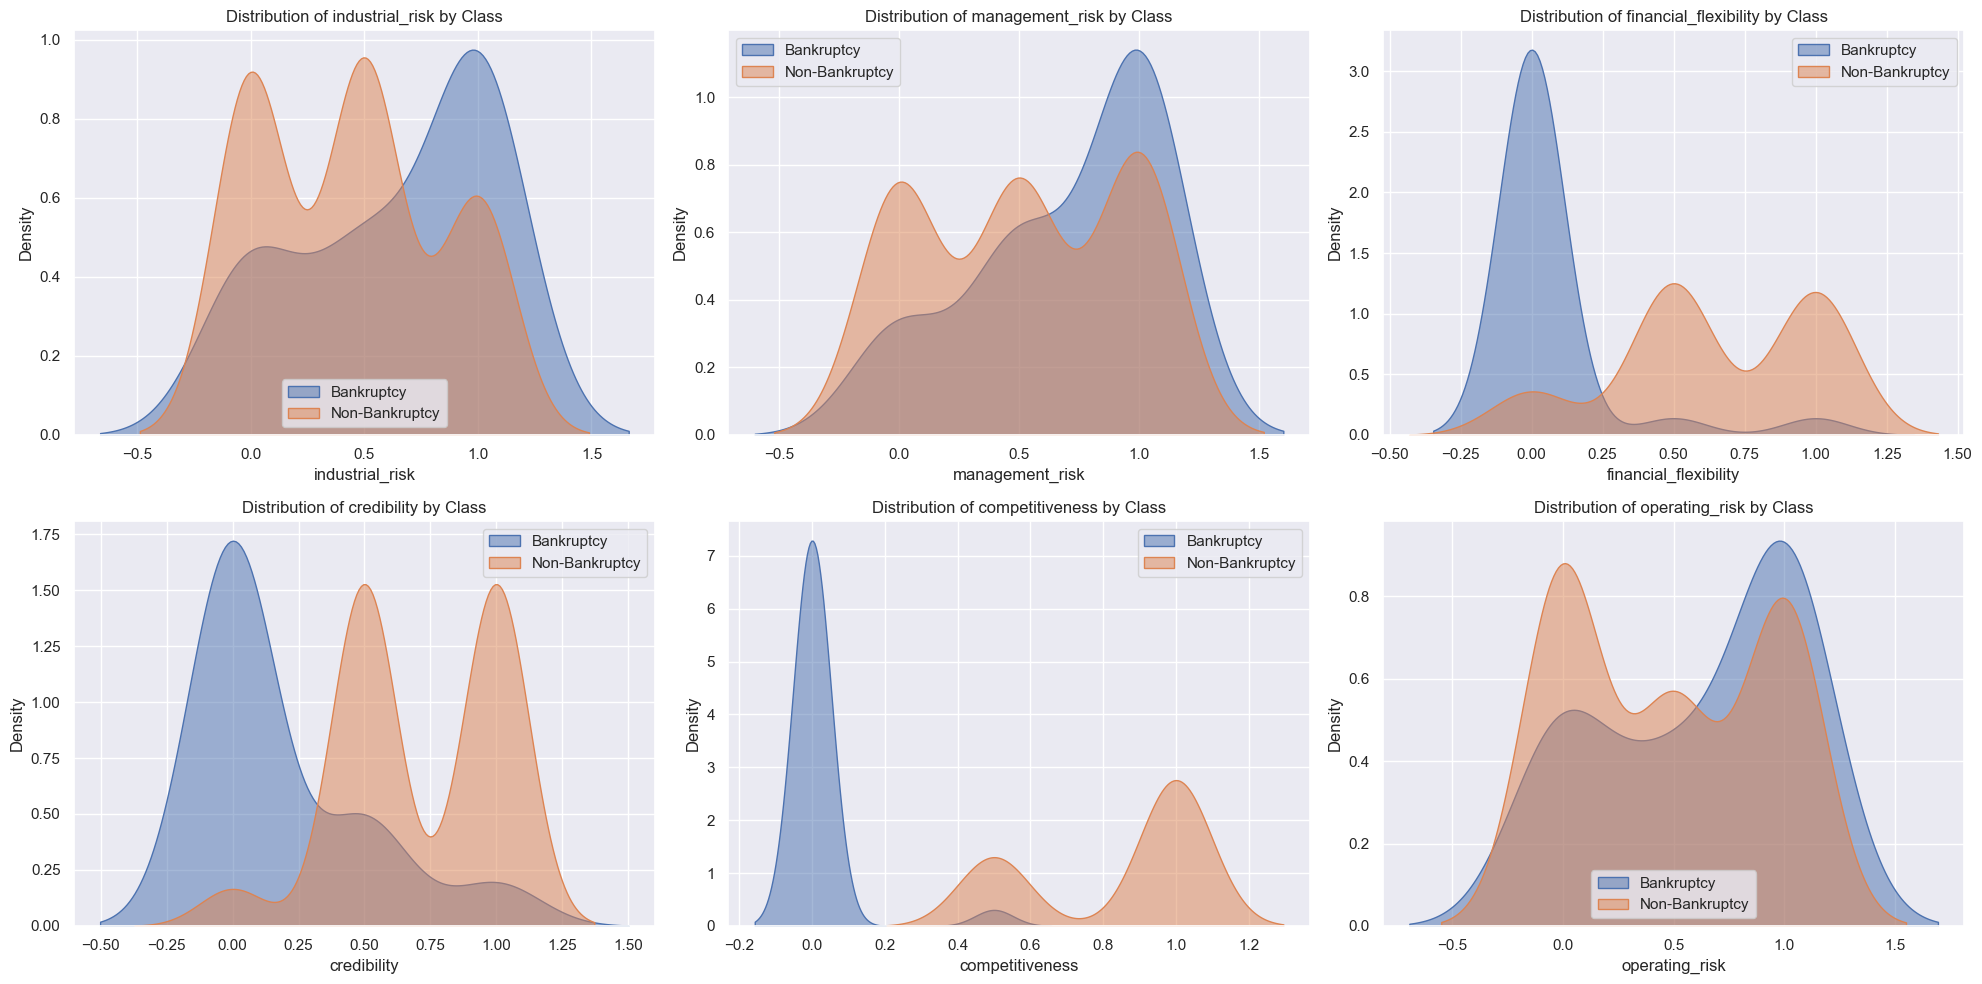

In [8]:
# KDE Plots for Feature Distributions
fig = plt.figure(figsize=(20, 10))

for idx, feature in enumerate(features, 1):
    plt.subplot(2, 3, idx)
    
    # Create KDE plot for each class
    sns.kdeplot(data=df[df['class']=='bankruptcy'][feature], label='Bankruptcy', fill=True, alpha=0.5)
    sns.kdeplot(data=df[df['class']=='non-bankruptcy'][feature], label='Non-Bankruptcy', fill=True, alpha=0.5)
    
    plt.title(f'Distribution of {feature} by Class')
    plt.legend()

plt.tight_layout()
plt.show()

### Violin Plots – Feature Distributions by Class

Violin plots combine boxplots and density estimates, showing both distribution shape and summary statistics for each feature by bankruptcy status.

Key insights: Financial Flexibility and Credibility clearly separate classes, Management and Operating Risks show higher medians for bankruptcy cases, while Industrial Risk exhibits significant overlap, indicating lower predictive power.

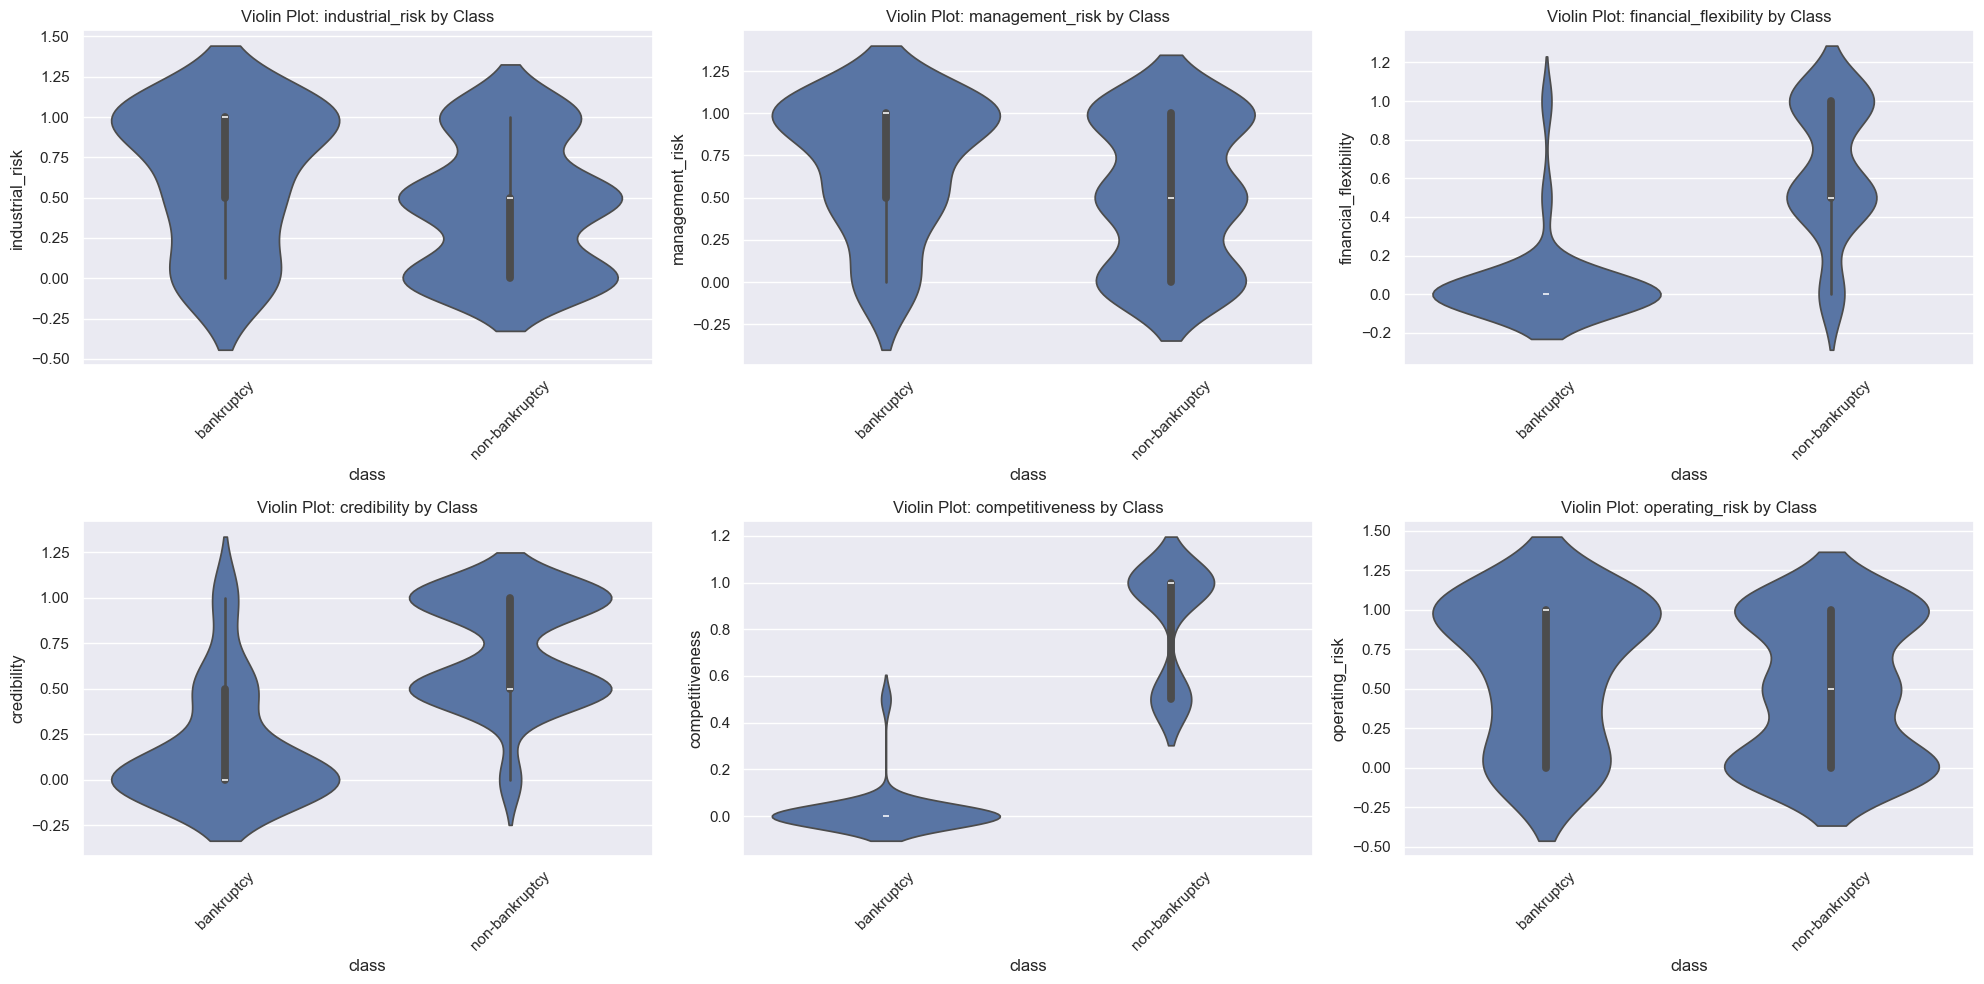

In [9]:
# Violin Plots for each feature
fig = plt.figure(figsize=(20, 10))

for idx, feature in enumerate(features, 1):
    plt.subplot(2, 3, idx)
    sns.violinplot(data=df, x='class', y=feature)
    plt.title(f'Violin Plot: {feature} by Class')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Enhanced Correlation Analysis

Computes correlations between all features and the target, converting the target to numeric for clarity.

The heatmap (upper-triangle) highlights strong positive and negative correlations, helping identify key predictors and feature relationships for bankruptcy prediction.

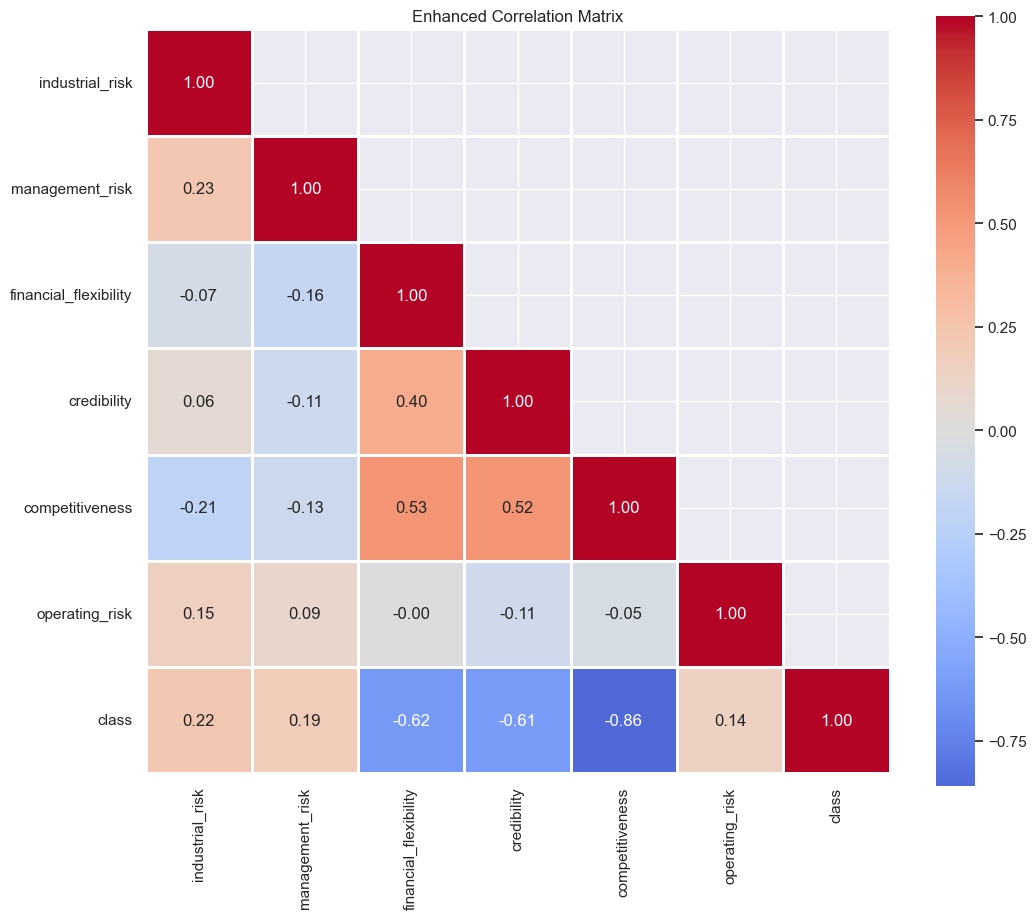

In [10]:
# Enhanced Correlation Analysis
df_numeric = df.copy()
df_numeric['class'] = (df_numeric['class'] == 'bankruptcy').astype(int)
correlation_matrix = df_numeric.corr()

# Plot enhanced heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            linewidths=1)
plt.title('Enhanced Correlation Matrix')
plt.show()

### Feature Importance – Correlation-Based

Bar chart ranks features by absolute correlation with bankruptcy, highlighting their predictive power.

Key insights: Financial Flexibility and Credibility are the strongest predictors, Management Risk is moderately important, while Industrial Risk and Operating Risk show weaker correlations.

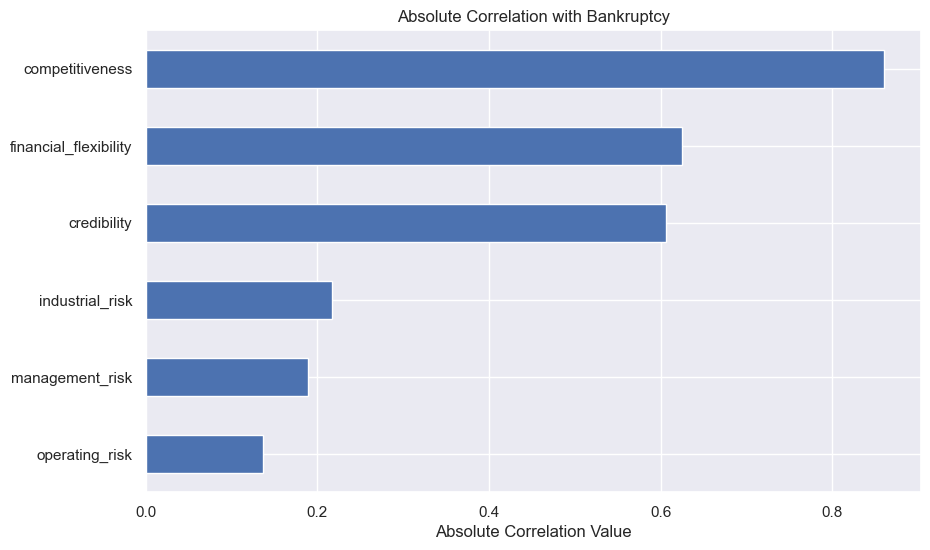

In [11]:
# Feature Importance based on Correlation
correlations = correlation_matrix['class'].drop('class')
plt.figure(figsize=(10, 6))
correlations.abs().sort_values(ascending=True).plot(kind='barh')
plt.title('Absolute Correlation with Bankruptcy')
plt.xlabel('Absolute Correlation Value')
plt.show()

### Pairwise Joint Plot Analysis

Scatter plots explore relationships between the top correlated features and Operating Risk, colored by bankruptcy status.

Key insights: Clear class separation, non-linear relationships, and clustering patterns highlight interactions between features that may influence bankruptcy risk.

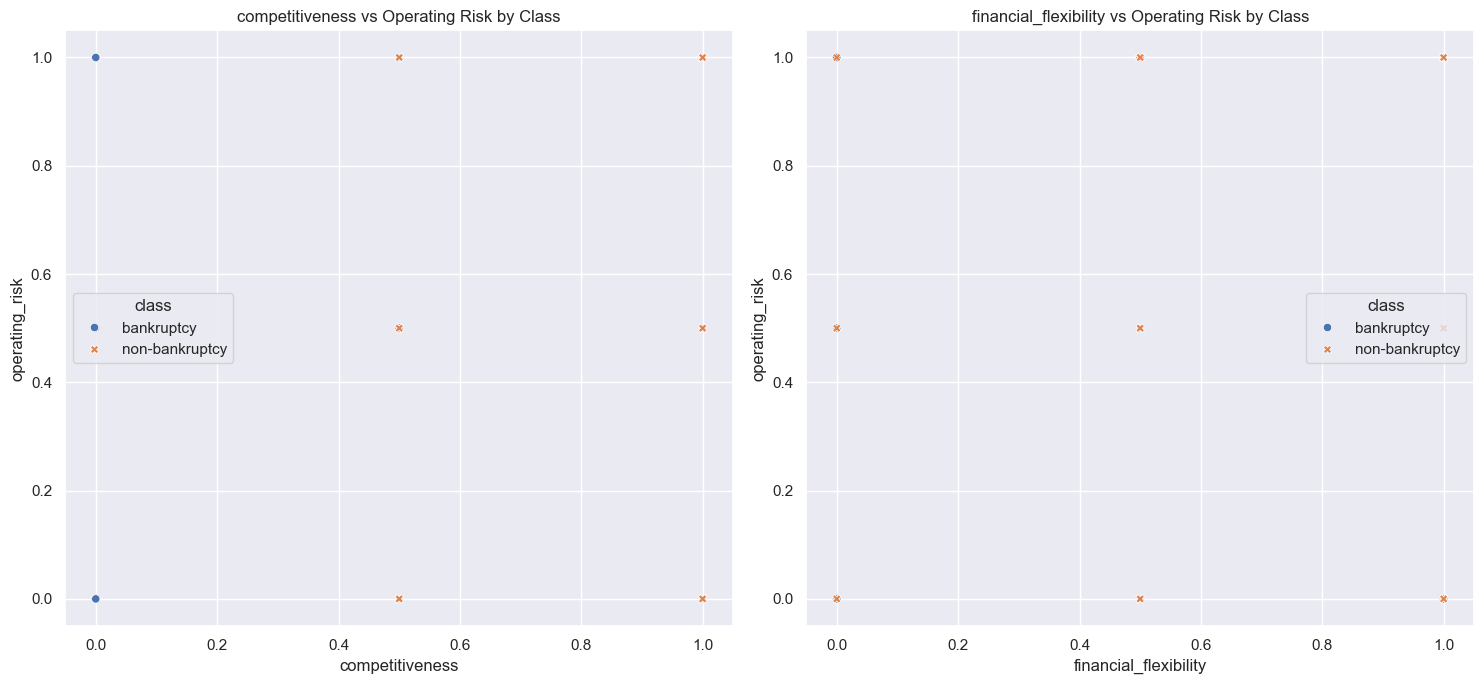

In [12]:
# Pairwise Joint Plots for Most Correlated Features
top_features = correlations.abs().sort_values(ascending=False)[:2].index

fig = plt.figure(figsize=(15, 7))
for idx, feature in enumerate(top_features, 1):
    plt.subplot(1, 2, idx)
    sns.scatterplot(data=df, x=feature, y='operating_risk', hue='class', style='class')
    plt.title(f'{feature} vs Operating Risk by Class')
    
plt.tight_layout()
plt.show()

## Feature Engineering

Created new features in three categories: correlation-based, statistical, and domain knowledge, plus interaction features (financial_x_management, risk_x_operational) to capture combined effects.

Applied MinMax scaling to standardize all numeric features for modeling.

Visualized feature distributions by class (boxplots) and correlations among engineered features (heatmap) to assess predictive patterns.

Enhanced dataset saved as 'bankruptcy_with_features.csv' for further modeling.

=== Feature Summary Statistics (Before Scaling) ===
       industrial_risk  management_risk  financial_flexibility  credibility  \
count          103.000          103.000                103.000      103.000   
mean             0.485            0.563                  0.505        0.583   
std              0.405            0.412                  0.405        0.378   
min              0.000            0.000                  0.000        0.000   
25%              0.000            0.000                  0.000        0.500   
50%              0.500            0.500                  0.500        0.500   
75%              1.000            1.000                  1.000        1.000   
max              1.000            1.000                  1.000        1.000   

       competitiveness  operating_risk  financial_health_score  \
count          103.000         103.000                 103.000   
mean             0.641           0.515                   0.576   
std              0.411           0.440

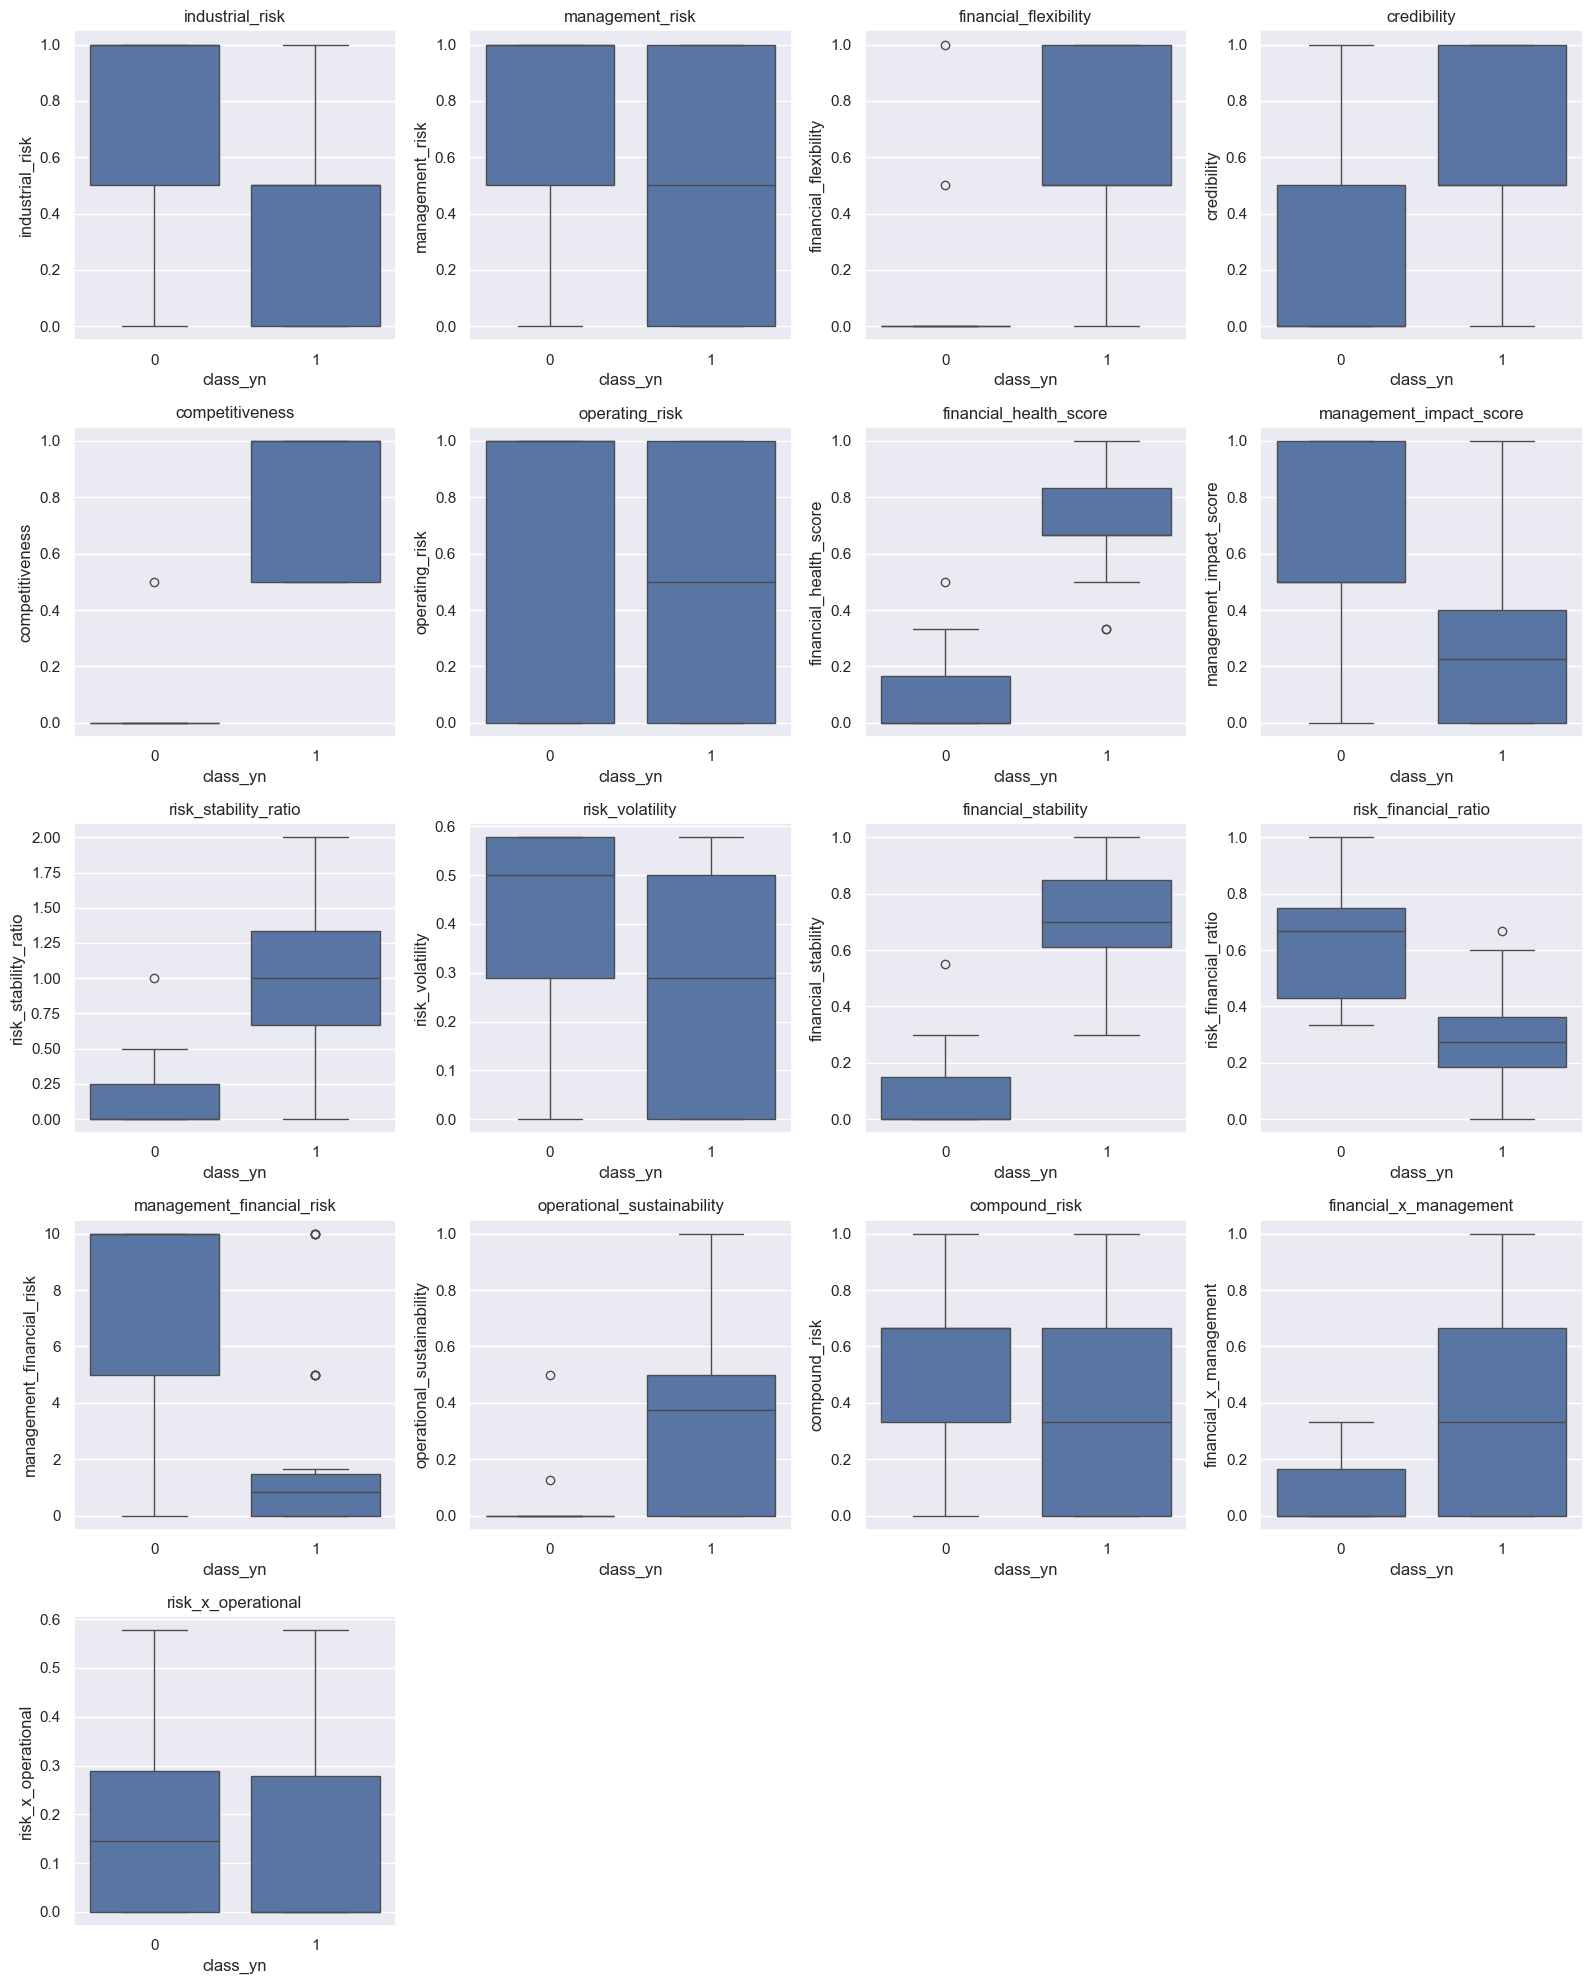

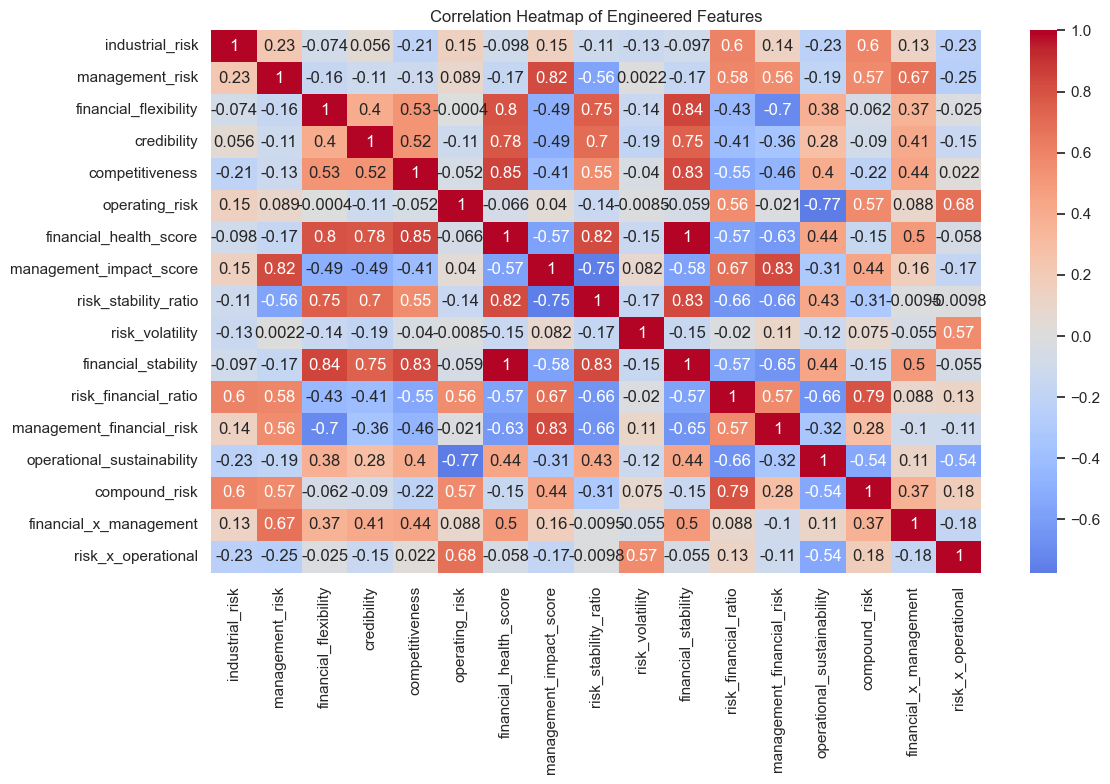


Enhanced dataset saved as 'bankruptcy_with_features.csv'


In [13]:
# --- Feature Engineering ---
def create_features(df):
    df_featured = df.copy()
    
    risk_cols = ['industrial_risk', 'management_risk', 'operating_risk']
    financial_cols = ['financial_flexibility', 'credibility', 'competitiveness']
    
    # Correlation-based
    df_featured['financial_health_score'] = df_featured[financial_cols].mean(axis=1)
    df_featured['management_impact_score'] = df_featured['management_risk'] / (df_featured['financial_flexibility'] + df_featured['credibility'] + 1)
    df_featured['risk_stability_ratio'] = (df_featured['financial_flexibility'] + df_featured['credibility']) / (df_featured['management_risk'] + 1)
    
    # Statistical
    df_featured['risk_volatility'] = df_featured[risk_cols].std(axis=1)
    weights = {'financial_flexibility':0.4,'credibility':0.3,'competitiveness':0.3}
    df_featured['financial_stability'] = sum(df_featured[col]*w for col,w in weights.items())
    df_featured['risk_financial_ratio'] = df_featured[risk_cols].mean(axis=1)/(df_featured[financial_cols].mean(axis=1)+1)
    
    # Domain knowledge
    df_featured['management_financial_risk'] = df_featured['management_risk'] / (df_featured['financial_flexibility'] + 0.1)
    df_featured['operational_sustainability'] = ((df_featured['financial_flexibility'] + df_featured['competitiveness'])/2)*(1-df_featured['operating_risk'])
    risk_threshold = 0.7
    df_featured['compound_risk'] = (df_featured[risk_cols] > risk_threshold).sum(axis=1)/len(risk_cols)
    
    # Interaction features
    df_featured['financial_x_management'] = df_featured['financial_health_score'] * df_featured['management_risk']
    df_featured['risk_x_operational'] = df_featured['risk_volatility'] * df_featured['operating_risk']
    
    return df_featured

# ---  Binary Target ---
df['class_yn'] = (df['class'] != 'bankruptcy').astype(int)  # 1=non-bankruptcy, 0=bankruptcy

# ---  Apply Feature Engineering ---
df_featured = create_features(df)

# --- Get numeric features (before scaling) ---
numeric_features = df_featured.select_dtypes(include=np.number).columns.tolist()
numeric_features.remove('class_yn')  # exclude target

# ---  Summary Statistics (Text Output) ---
print("=== Feature Summary Statistics (Before Scaling) ===")
summary_stats = df_featured[numeric_features].describe()
print(summary_stats.round(3))

# ---  Plots ---

# Feature distributions by class

n = len(numeric_features)
cols = 4
rows = math.ceil(n / cols)  # dynamically calculate number of rows

plt.figure(figsize=(cols*4, rows*4))  # adjust figure size dynamically
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x='class_yn', y=feature, data=df_featured)
    plt.title(feature)
plt.tight_layout()
plt.show()


# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_featured[numeric_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Engineered Features")
plt.tight_layout()
plt.show()

# --- Save CSV ---
df_featured.to_csv('bankruptcy_with_features.csv', index=False)
print("\nEnhanced dataset saved as 'bankruptcy_with_features.csv'")


## Data Preprocessing – Train/Test Split

Defined features (x) and target (y), then split the data into training (75%) and testing (25%) sets with stratification to preserve class balance.

Applied MinMax scaling to training data only, then transformed test data using the fitted scaler to prevent data leakage.

Used a fixed random state for reproducibility and confirmed the dataset sizes.

In [14]:
# --- Define Features and Target (before scaling) ---
X = df_featured[numeric_features]  # unscaled numeric features
y = df_featured['class_yn']        # target: 1=non-bankruptcy, 0=bankruptcy

# --- Split into Training and Testing Sets FIRST (prevents data leakage) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,       # 25% of data for testing
    random_state=42,     # ensures reproducibility
    stratify=y           # preserves class distribution
)

# --- Feature Scaling (fit on training data only) ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)      # Fit scaler on training data
X_test_scaled = scaler.transform(X_test)             # Transform test data using fitted scaler

# Convert back to DataFrames to preserve column names
X_train = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test.index)

# --- Check Shapes ---
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Scaler fitted on training data with {len(numeric_features)} features")

Training set: 77 samples
Testing set: 26 samples
Scaler fitted on training data with 17 features



## Model Building and Evaluation

We trained and evaluated five classification models to predict bankruptcy risk:

- Logistic Regression – simplest model, provides a baseline for comparison.

- K-Nearest Neighbors (KNN) – distance-based model; using a larger k helps reduce overfitting while still leveraging scaled features.

- Random Forest – robust ensemble model, handles nonlinear relationships and feature interactions well.

- XGBoost – gradient boosting algorithm, effective for structured data and capable of capturing complex patterns.

- LightGBM – fast gradient boosting implementation, similar to XGBoost, useful for comparison and large datasets.

Visualized results with a 2×2 grid showing confusion matrix, ROC curve, feature coefficients, and predicted probability distributions.

## Hyperparameter Tuning with GridSearchCV

Optimize each model with grid search cross-validation to find the best hyperparameters. This systematically searches through specified parameter combinations and evaluates them using cross-validation to prevent overfitting.

GridSearchCV uses:
- 5-fold stratified CV for robust validation
- F1-score as primary optimization metric (balanced precision/recall)
- Combination of core hyperparameters most impactful for each algorithm

In [15]:
# Configure a warning filter to avoid GridSearchCV convergence warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 6, 8, None],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2', None]
    },
    'Decision Tree': {
        'max_depth': [3, 4, 5, 6, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'class_weight': [None, 'balanced']
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 6, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'subsample': [0.8, 0.9, 1.0]
    }
}

# Define base models
base_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42),
    'LightGBM': lgb.LGBMClassifier(verbose=-1, random_state=42)
}

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize container for tuned models
tuned_models = {}
best_params = {}
cv_scores = {}

print("Starting hyperparameter tuning for all models:")
print("="*80)

# Perform grid search for each model
for model_name, base_model in base_models.items():
    print(f"\nTuning {model_name}...")
    start_time = time.time()
    
    # Create grid search
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grids[model_name],
        cv=cv_strategy,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit grid search
    grid.fit(X_train_scaled, y_train)
    
    # Store best model, parameters and scores
    tuned_models[model_name] = grid.best_estimator_
    best_params[model_name] = grid.best_params_
    cv_scores[model_name] = grid.best_score_
    
    # Print results
    duration = time.time() - start_time
    print(f"  Best CV F1-score: {grid.best_score_:.4f}")
    print(f"  Best parameters: {grid.best_params_}")
    print(f"  Time: {duration:.2f} seconds")

print("\n" + "="*80)
print("Hyperparameter tuning completed!")

Starting hyperparameter tuning for all models:

Tuning Logistic Regression...
  Best CV F1-score: 1.0000
  Best parameters: {'C': 1.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
  Time: 13.45 seconds

Tuning KNN...
  Best CV F1-score: 1.0000
  Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
  Time: 0.69 seconds

Tuning Random Forest...
  Best CV F1-score: 1.0000
  Best parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
  Time: 47.01 seconds

Tuning Decision Tree...
  Best CV F1-score: 0.9913
  Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Time: 2.36 seconds

Tuning SVM...
  Best CV F1-score: 1.0000
  Best parameters: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
  Time: 2.21 seconds

Tuning XGBoost...
  Best CV F1-score: 0.9913
  Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n

### Logistic Regression – Training and Evaluation

Trained a Logistic Regression model on scaled features to predict bankruptcy risk.

Captures linear relationships between features and bankruptcy probability.

Useful for interpreting feature impact through model coefficients.

=== Logistic Regression Metrics ===
Accuracy: 0.9615

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.95      1.00      0.98        20

    accuracy                           0.96        26
   macro avg       0.98      0.92      0.94        26
weighted avg       0.96      0.96      0.96        26



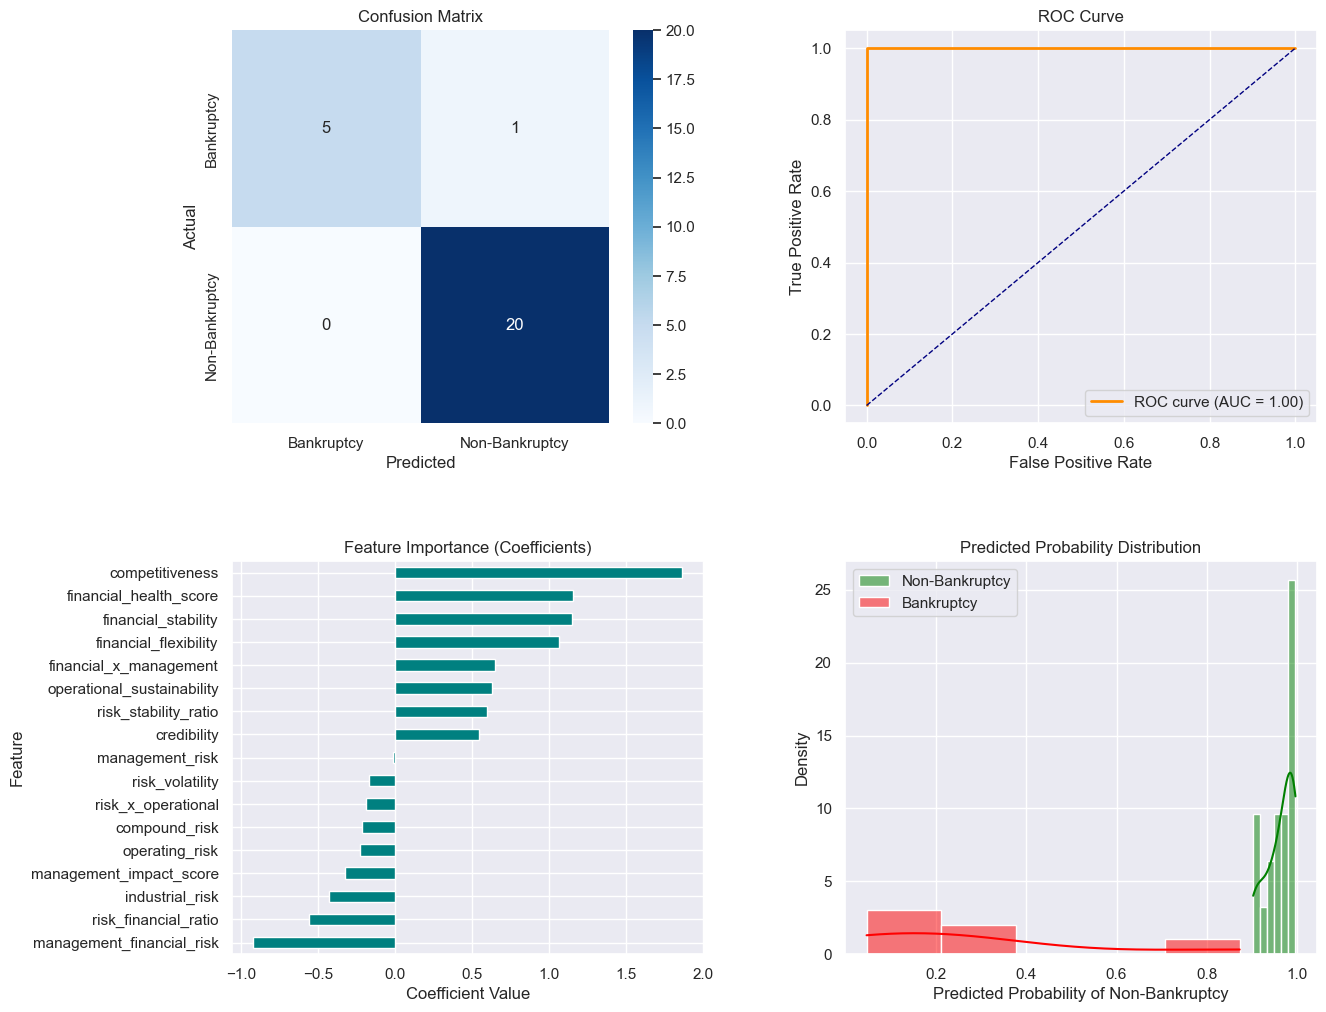

In [16]:
# --- Train Logistic Regression ---
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train, y_train)

# --- Predictions ---
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]  # probability for class 1 (non-bankruptcy)

# --- Basic Metrics ---
print("=== Logistic Regression Metrics ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Prepare metrics for plots ---
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
coef = lr_model.coef_[0]
feature_importance = pd.Series(coef, index=X_train.columns).sort_values()

# --- Plot all visuals in 2x2 grid with spacing ---
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# --- Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bankruptcy','Non-Bankruptcy'], 
            yticklabels=['Bankruptcy','Non-Bankruptcy'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# --- ROC Curve ---
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0,1].plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc='lower right')

# --- Feature Coefficients ---
feature_importance.plot(kind='barh', color='teal', ax=axes[1,0])
axes[1,0].set_title('Feature Importance (Coefficients)')
axes[1,0].set_xlabel('Coefficient Value')
axes[1,0].set_ylabel('Feature')

# --- Predicted Probability Distribution ---
sns.histplot(y_proba[y_test==1], color='green', label='Non-Bankruptcy', kde=True, stat='density', ax=axes[1,1])
sns.histplot(y_proba[y_test==0], color='red', label='Bankruptcy', kde=True, stat='density', ax=axes[1,1])
axes[1,1].set_title('Predicted Probability Distribution')
axes[1,1].set_xlabel('Predicted Probability of Non-Bankruptcy')
axes[1,1].legend()

# --- Adjust spacing between plots ---
plt.subplots_adjust(hspace=0.35, wspace=0.3)  # vertical and horizontal gaps
plt.show()


### K-Nearest Neighbors (KNN) – Training and Evaluation

KNN is a non-parametric, instance-based learning algorithm that classifies a data point based on the majority class of its nearest neighbors in feature space.

Tuned k using GridSearchCV to avoid overfitting and capture local patterns.

Trained on scaled features, making it suitable for our small dataset.

Best k found: 5
=== KNN Metrics ===
Accuracy: 0.9615

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.95      1.00      0.98        20

    accuracy                           0.96        26
   macro avg       0.98      0.92      0.94        26
weighted avg       0.96      0.96      0.96        26



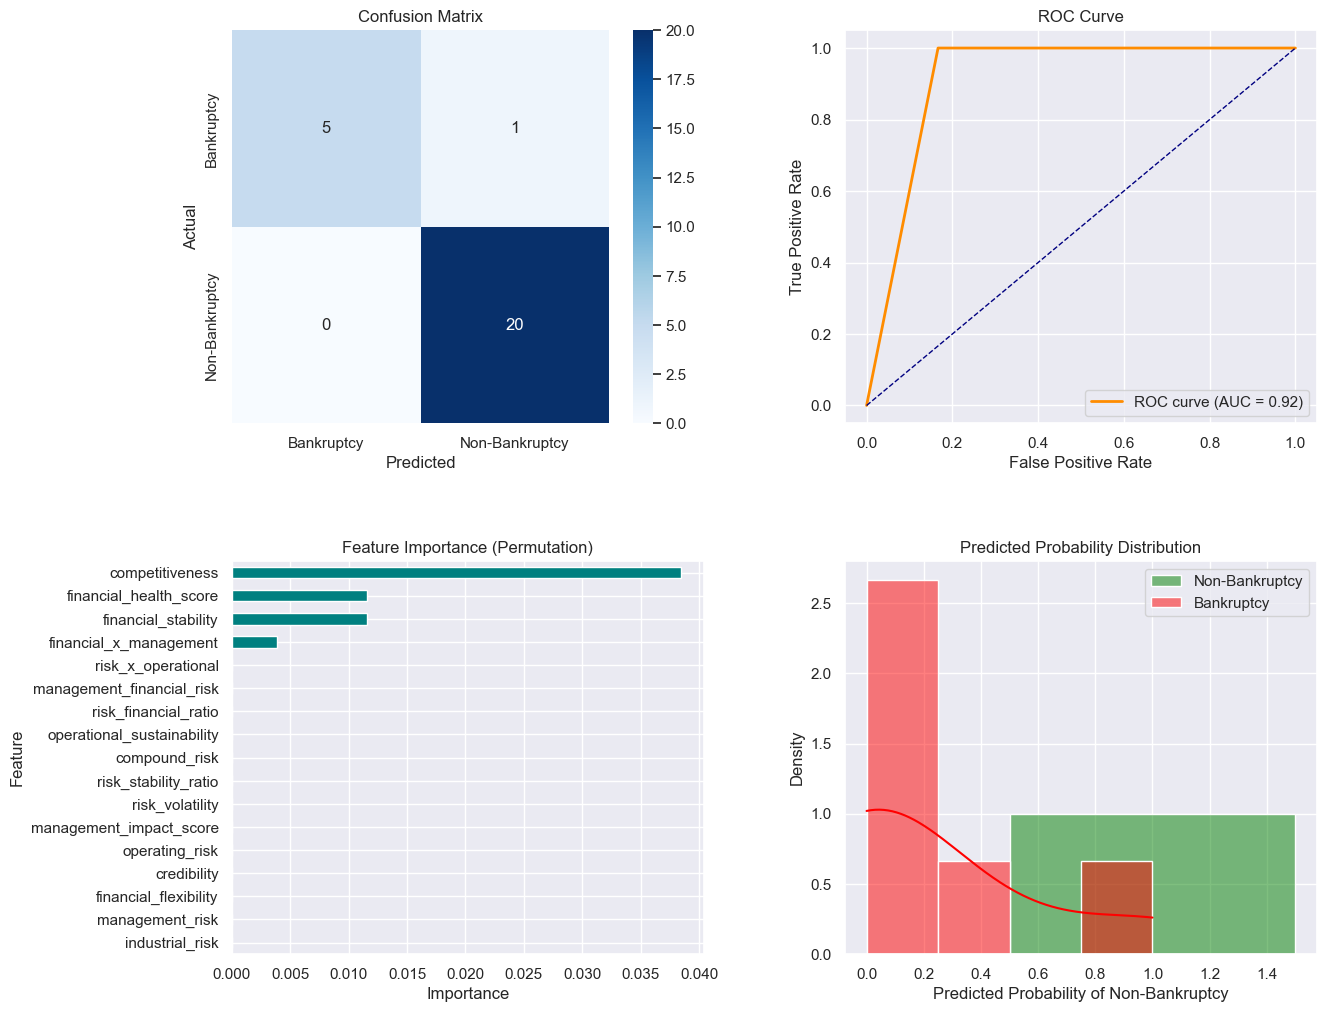

In [17]:
# --- Tune k using GridSearchCV ---
param_grid = {'n_neighbors': list(range(3, 21, 2))}  # odd k values to avoid ties
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
best_k = grid.best_params_['n_neighbors']
print(f"Best k found: {best_k}")

# --- Train KNN with best k ---
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

# --- Predictions ---
y_pred = knn_model.predict(X_test)
y_proba = knn_model.predict_proba(X_test)[:, 1]  # probability for class 1 (non-bankruptcy)

# --- Basic Metrics ---
print("=== KNN Metrics ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Prepare metrics for plots ---
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# --- Feature importance workaround for KNN ---
# KNN is non-parametric, so we don't have coefficients
# We'll use permutation importance for interpretability
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(knn_model, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.Series(perm_importance.importances_mean, index=X_train.columns).sort_values()

# --- Plot all visuals in 2x2 grid with spacing ---
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bankruptcy','Non-Bankruptcy'], 
            yticklabels=['Bankruptcy','Non-Bankruptcy'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0,1].plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc='lower right')

# Feature Importance (Permutation)
feature_importance.plot(kind='barh', color='teal', ax=axes[1,0])
axes[1,0].set_title('Feature Importance (Permutation)')
axes[1,0].set_xlabel('Importance')
axes[1,0].set_ylabel('Feature')

# Predicted Probability Distribution
sns.histplot(y_proba[y_test==1], color='green', label='Non-Bankruptcy', kde=True, stat='density', ax=axes[1,1])
sns.histplot(y_proba[y_test==0], color='red', label='Bankruptcy', kde=True, stat='density', ax=axes[1,1])
axes[1,1].set_title('Predicted Probability Distribution')
axes[1,1].set_xlabel('Predicted Probability of Non-Bankruptcy')
axes[1,1].legend()

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()


### Random Forest – Training and Evaluation

A Machine Learning method that builds multiple decision trees and aggregates their predictions to improve accuracy and reduce overfitting.

Trained with safeguards against overfitting (limited depth, moderate number of trees, min samples per split) to capture non-linear relationships and feature interactions for bankruptcy prediction.

Provides feature importance scores, helping identify the most influential predictors.

=== Random Forest Metrics ===
Accuracy: 0.9615

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.95      1.00      0.98        20

    accuracy                           0.96        26
   macro avg       0.98      0.92      0.94        26
weighted avg       0.96      0.96      0.96        26



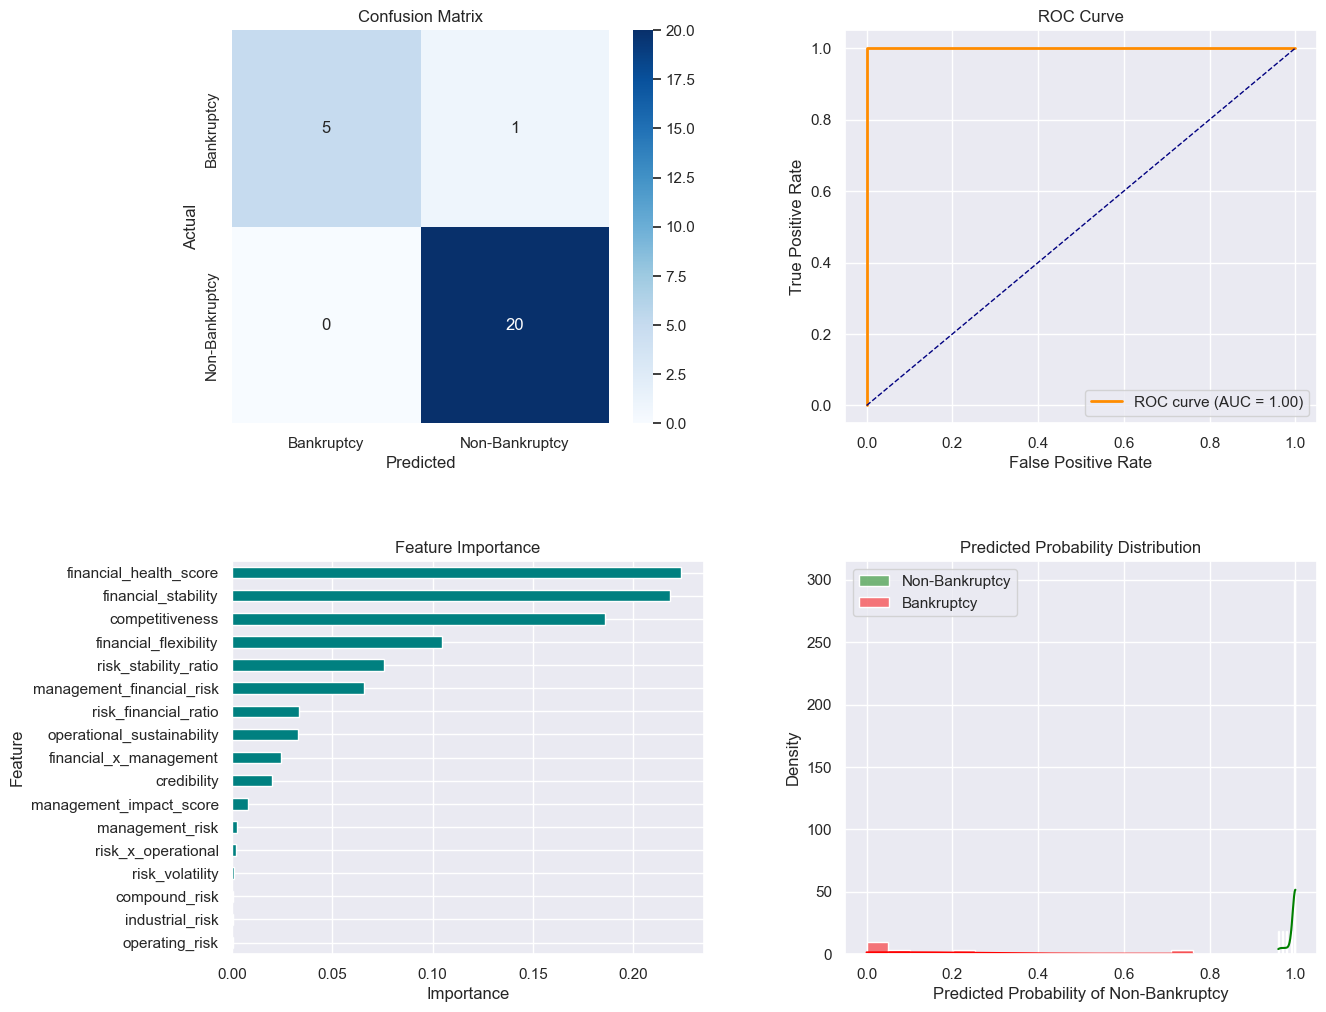

In [18]:
# --- Train Random Forest with overfitting safeguards ---
rf_model = RandomForestClassifier(
    n_estimators=100,       # more trees for better performance
    max_depth=None,         # allow deeper trees
    max_features='sqrt',    # reduce variance
    min_samples_split=2,    # default
    random_state=42
)
rf_model.fit(X_train, y_train)

# --- Predictions ---
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # probability for class 1 (non-bankruptcy)

# --- Basic Metrics ---
print("=== Random Forest Metrics ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Prepare metrics for plots ---
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Feature importance using built-in attribute
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values()

# --- Plot all visuals in 2x2 grid with spacing ---
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bankruptcy','Non-Bankruptcy'], 
            yticklabels=['Bankruptcy','Non-Bankruptcy'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0,1].plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc='lower right')

# Feature Importance (built-in)
feature_importance.plot(kind='barh', color='teal', ax=axes[1,0])
axes[1,0].set_title('Feature Importance')
axes[1,0].set_xlabel('Importance')
axes[1,0].set_ylabel('Feature')

# Predicted Probability Distribution (wider bins)
sns.histplot(y_proba[y_test==1], color='green', label='Non-Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
sns.histplot(y_proba[y_test==0], color='red', label='Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
axes[1,1].set_title('Predicted Probability Distribution')
axes[1,1].set_xlabel('Predicted Probability of Non-Bankruptcy')
axes[1,1].legend()

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()


### LightGBM – Training and Evaluation

LightGBM is a high-performance gradient boosting framework that builds decision trees sequentially, enabling fast and efficient processing of structured data.

The model uses regularization techniques—such as limiting tree depth, subsampling, and controlling feature fractions—to prevent overfitting while capturing complex non-linear relationships and feature interactions.

It provides feature importance scores to highlight key predictors, and its scalability and low memory usage make it well-suited for accurate and efficient bankruptcy prediction.

=== LightGBM Metrics ===
Accuracy: 0.9615

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.95      1.00      0.98        20

    accuracy                           0.96        26
   macro avg       0.98      0.92      0.94        26
weighted avg       0.96      0.96      0.96        26



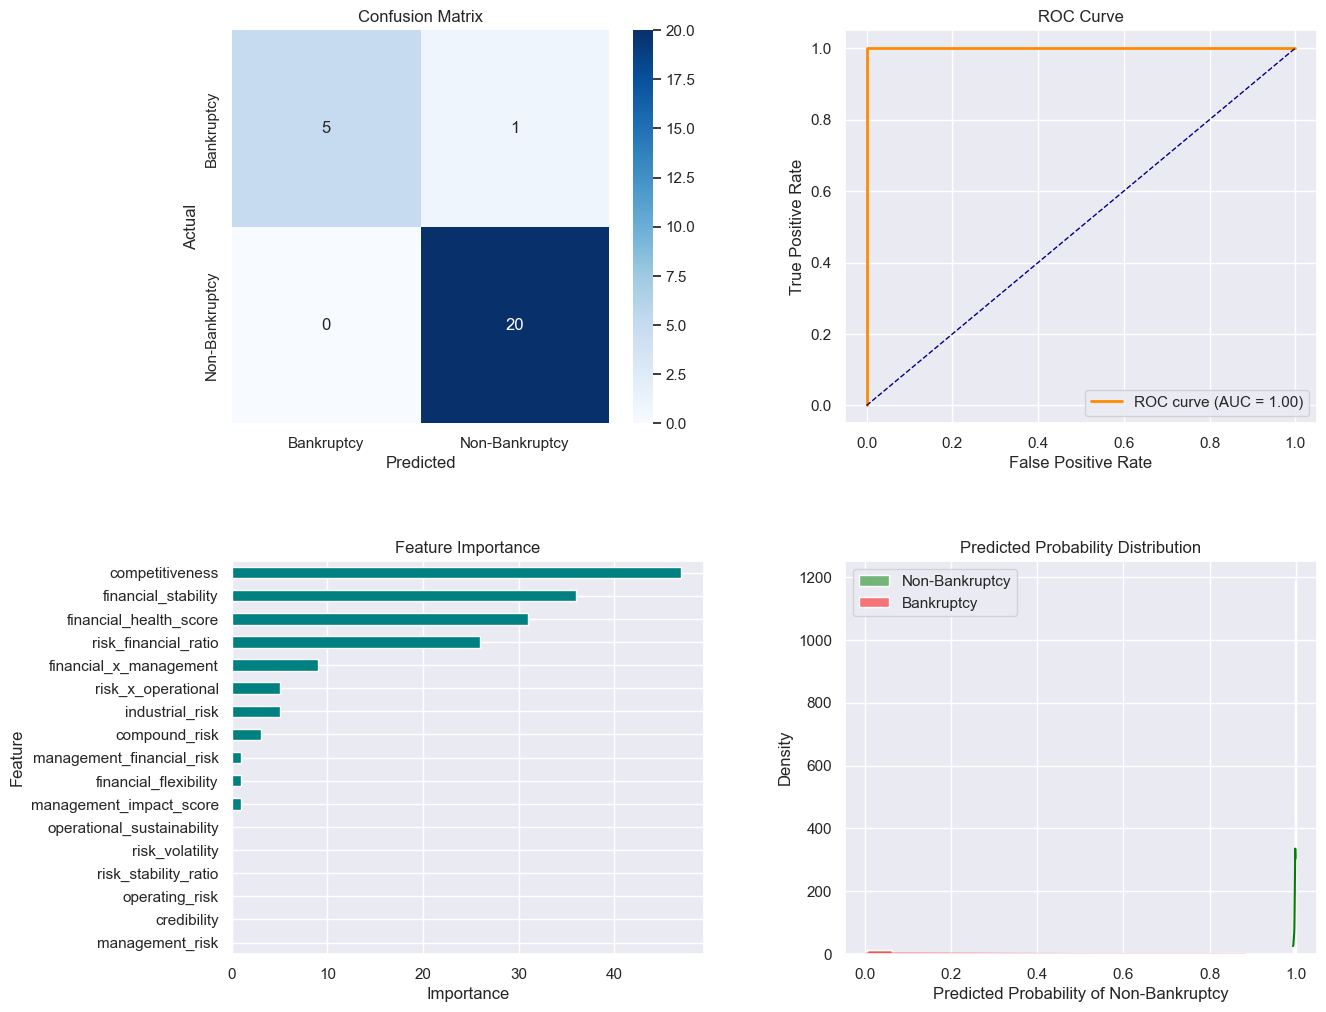

In [19]:
# --- Initialize LightGBM with overfitting safeguards ---
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1  # suppress LightGBM info/warnings
)

lgb_model.fit(X_train, y_train)


# --- Predictions ---
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]  # probability for class 1 (non-bankruptcy)

# --- Basic Metrics ---
print("=== LightGBM Metrics ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Prepare metrics for plots ---
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Feature importance
feature_importance = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values()

# --- Plot all visuals in 2x2 grid with spacing ---
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bankruptcy','Non-Bankruptcy'], 
            yticklabels=['Bankruptcy','Non-Bankruptcy'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0,1].plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc='lower right')

# Feature Importance
feature_importance.plot(kind='barh', color='teal', ax=axes[1,0])
axes[1,0].set_title('Feature Importance')
axes[1,0].set_xlabel('Importance')
axes[1,0].set_ylabel('Feature')

# Predicted Probability Distribution
sns.histplot(y_proba[y_test==1], color='green', label='Non-Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
sns.histplot(y_proba[y_test==0], color='red', label='Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
axes[1,1].set_title('Predicted Probability Distribution')
axes[1,1].set_xlabel('Predicted Probability of Non-Bankruptcy')
axes[1,1].legend()

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()


### XGBoost – Training and Evaluation

XGBoost is a high-performance gradient boosting framework that builds decision trees sequentially, optimized for speed, efficiency, and accuracy on structured data.

The model is trained with regularization techniques—such as limiting tree depth, subsampling, feature fraction, and minimum child weight—to prevent overfitting while capturing complex non-linear relationships and feature interactions.

It provides feature importance scores, highlighting the most influential predictors and enhancing model interpretability for bankruptcy prediction.

=== XGBoost Metrics ===
Accuracy: 0.9615

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.95      1.00      0.98        20

    accuracy                           0.96        26
   macro avg       0.98      0.92      0.94        26
weighted avg       0.96      0.96      0.96        26



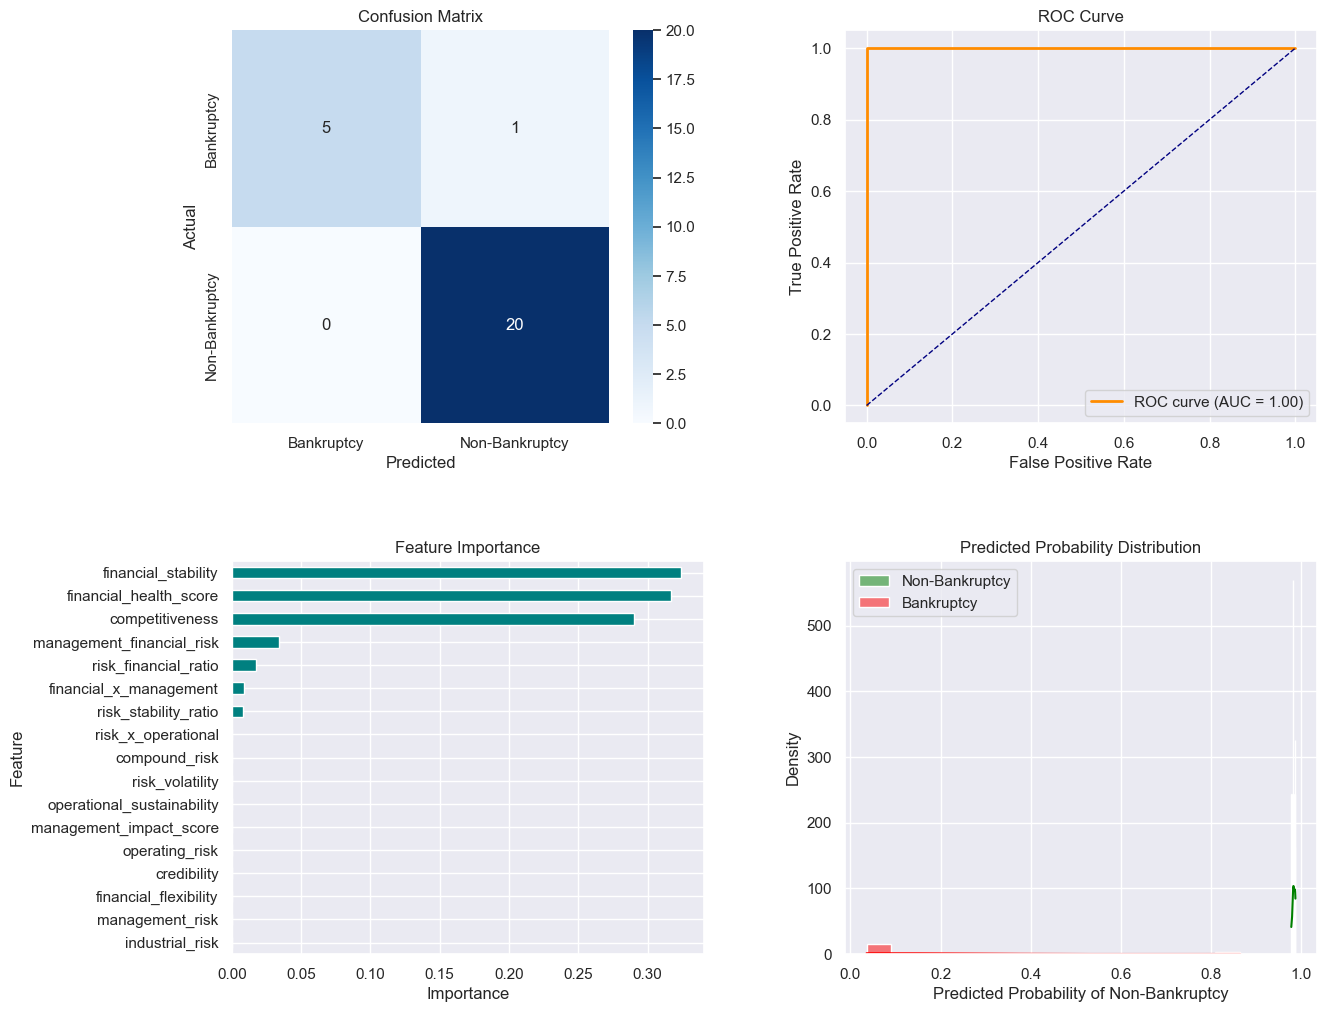

In [20]:
# --- Initialize XGBoost with overfitting safeguards ---
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=0  # suppress info/warnings
)

# --- Fit model with stdout temporarily silenced ---
stdout_fileno = sys.stdout
sys.stdout = open(os.devnull, 'w')  # Redirect stdout to null

xgb_model.fit(X_train, y_train)

# Restore stdout
sys.stdout.close()
sys.stdout = stdout_fileno

# ---  Predictions ---
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # probability for class 1 (non-bankruptcy)

# --- Basic Metrics ---
print("=== XGBoost Metrics ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Prepare metrics for plots ---
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Feature importance
feature_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values()

# --- Plot all visuals in 2x2 grid with spacing ---
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bankruptcy','Non-Bankruptcy'], 
            yticklabels=['Bankruptcy','Non-Bankruptcy'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0,1].plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc='lower right')

# Feature Importance
feature_importance.plot(kind='barh', color='teal', ax=axes[1,0])
axes[1,0].set_title('Feature Importance')
axes[1,0].set_xlabel('Importance')
axes[1,0].set_ylabel('Feature')

# Predicted Probability Distribution
sns.histplot(y_proba[y_test==1], color='green', label='Non-Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
sns.histplot(y_proba[y_test==0], color='red', label='Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
axes[1,1].set_title('Predicted Probability Distribution')
axes[1,1].set_xlabel('Predicted Probability of Non-Bankruptcy')
axes[1,1].legend()

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()


### Decision Tree – Training and Evaluation

Decision Tree is a non-parametric model that recursively splits features to maximize information gain. 

It's interpretable, handles nonlinear patterns, and provides feature importances. Regularization via max_depth, min_samples_split prevents overfitting.

=== Decision Tree Metrics ===
Accuracy: 0.9615

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.95      1.00      0.98        20

    accuracy                           0.96        26
   macro avg       0.98      0.92      0.94        26
weighted avg       0.96      0.96      0.96        26



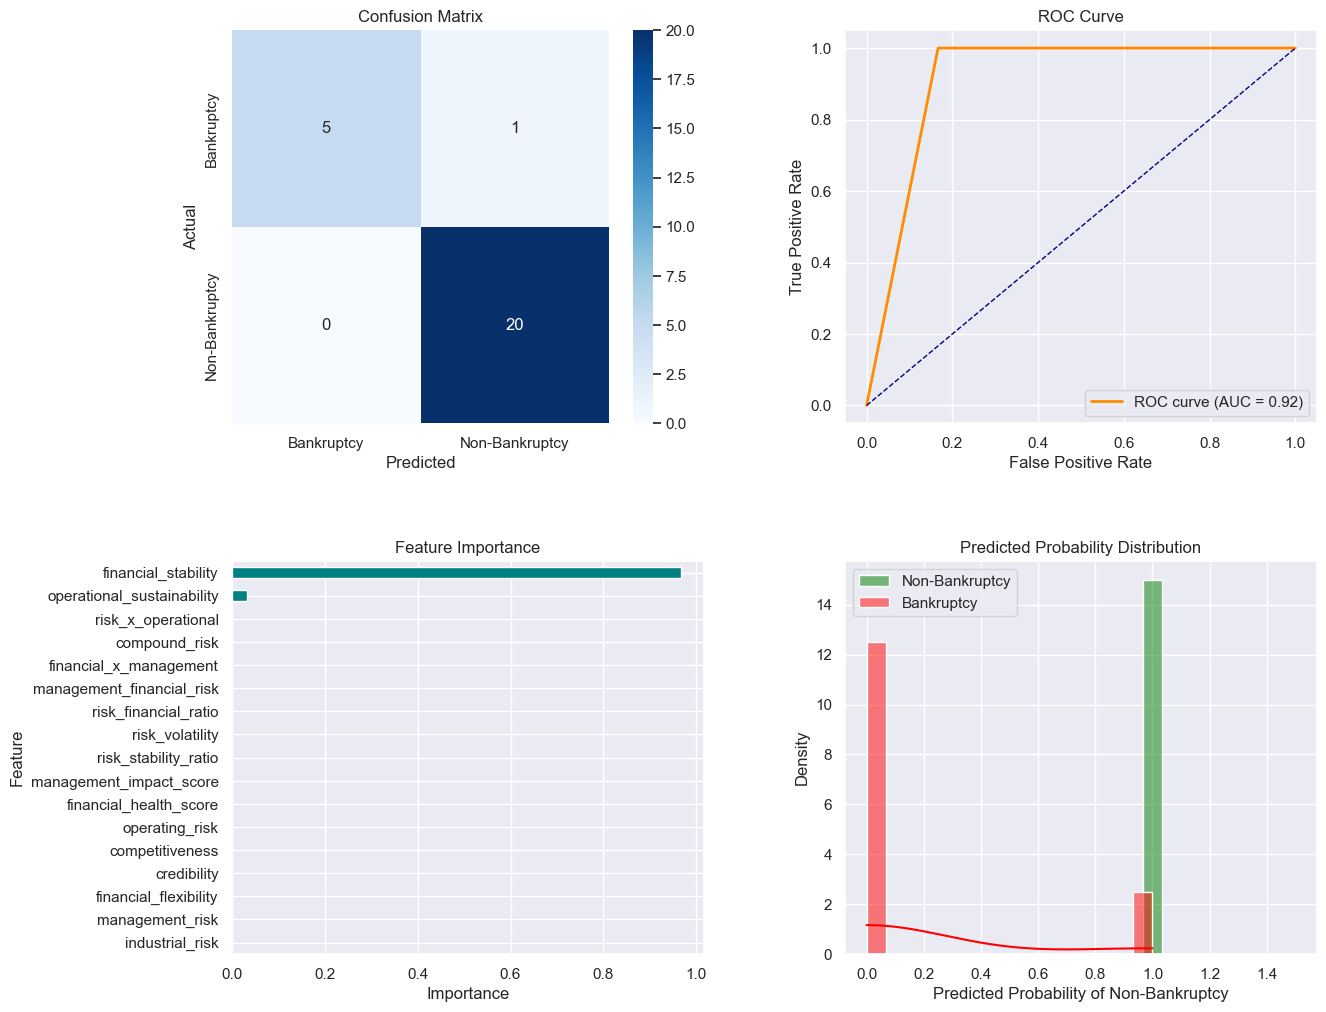

In [21]:
# --- Initialize Decision Tree with regularization ---
dt_model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# --- Fit model ---
dt_model.fit(X_train_scaled, y_train)

# --- Predictions ---
y_pred = dt_model.predict(X_test_scaled)
y_proba = dt_model.predict_proba(X_test_scaled)[:, 1]

# --- Basic Metrics ---
print("=== Decision Tree Metrics ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Prepare metrics for plots ---
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Feature importance
feature_importance = pd.Series(dt_model.feature_importances_, index=X_train.columns).sort_values()

# --- Plot all visuals in 2x2 grid with spacing ---
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bankruptcy','Non-Bankruptcy'], 
            yticklabels=['Bankruptcy','Non-Bankruptcy'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0,1].plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc='lower right')

# Feature Importance
feature_importance.plot(kind='barh', color='teal', ax=axes[1,0])
axes[1,0].set_title('Feature Importance')
axes[1,0].set_xlabel('Importance')
axes[1,0].set_ylabel('Feature')

# Predicted Probability Distribution
sns.histplot(y_proba[y_test==1], color='green', label='Non-Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
sns.histplot(y_proba[y_test==0], color='red', label='Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
axes[1,1].set_title('Predicted Probability Distribution')
axes[1,1].set_xlabel('Predicted Probability of Non-Bankruptcy')
axes[1,1].legend()

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

### Support Vector Machine (SVM) – Training and Evaluation

Support Vector Machine finds the optimal hyperplane that maximizes the margin between classes. 

Uses RBF kernel (handles nonlinear decision boundaries), C=1.0 (regularization parameter), and class_weight='balanced' to handle potential class imbalance.

=== SVM Metrics ===
Accuracy: 0.9615

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.95      1.00      0.98        20

    accuracy                           0.96        26
   macro avg       0.98      0.92      0.94        26
weighted avg       0.96      0.96      0.96        26



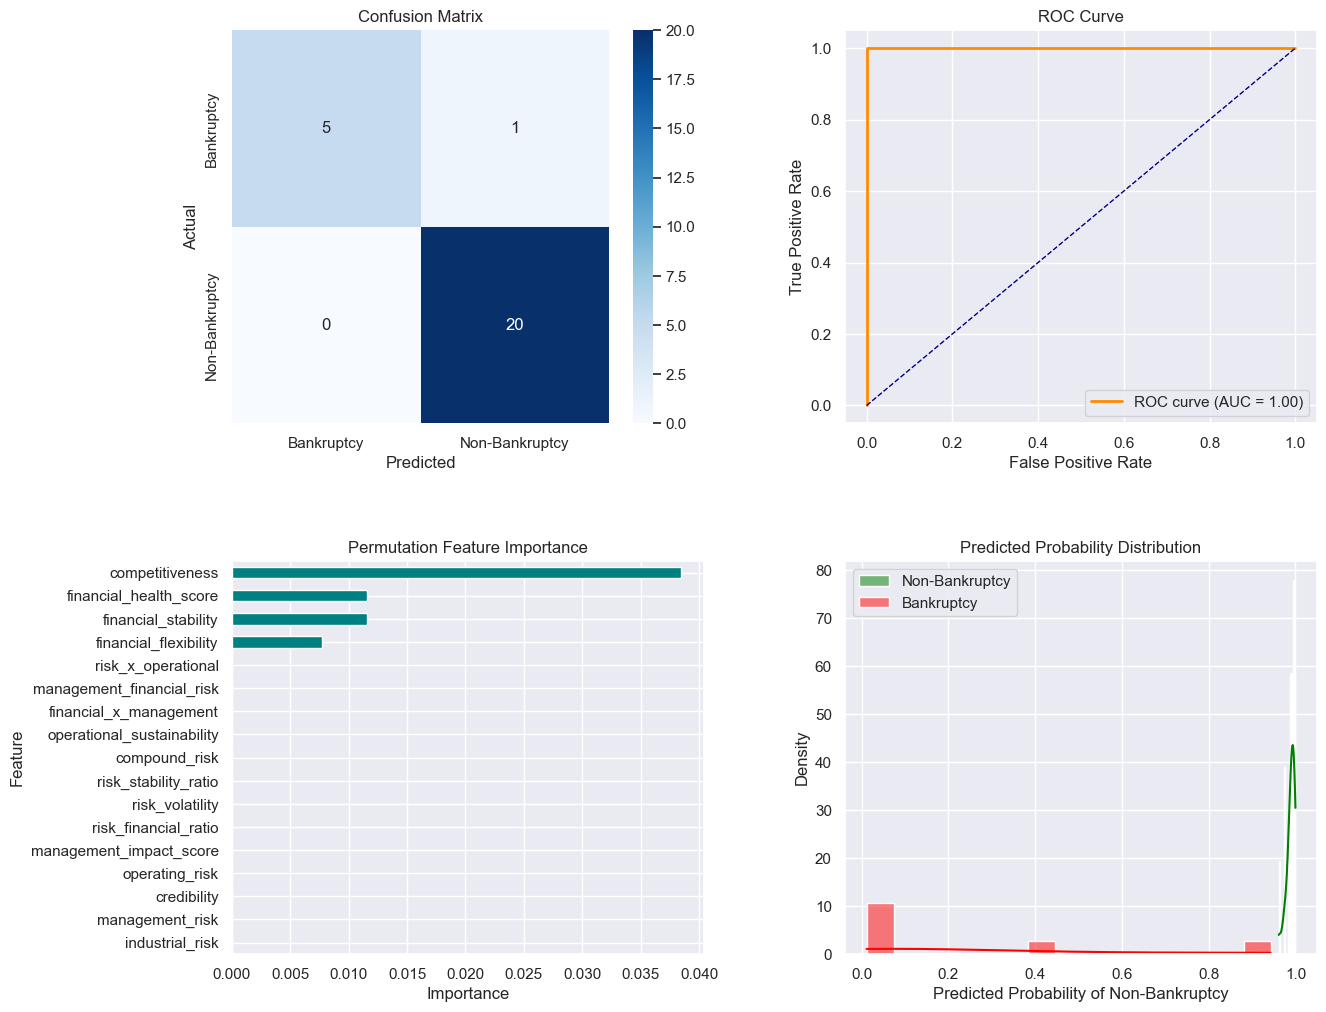

In [22]:
# --- Initialize SVM with RBF kernel ---
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    class_weight='balanced',
    probability=True,  # enable predict_proba
    random_state=42
)

# --- Fit model ---
svm_model.fit(X_train_scaled, y_train)

# --- Predictions ---
y_pred = svm_model.predict(X_test_scaled)
y_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# --- Basic Metrics ---
print("=== SVM Metrics ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Prepare metrics for plots ---
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# --- Plot all visuals in 2x2 grid with spacing ---
fig, axes = plt.subplots(2, 2, figsize=(14,12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bankruptcy','Non-Bankruptcy'], 
            yticklabels=['Bankruptcy','Non-Bankruptcy'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0,1].plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc='lower right')

# Permutation Importance (SVM doesn't have feature_importances_)
perm_importance = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
feature_importance = pd.Series(perm_importance.importances_mean, index=X_train.columns).sort_values()

feature_importance.plot(kind='barh', color='teal', ax=axes[1,0])
axes[1,0].set_title('Permutation Feature Importance')
axes[1,0].set_xlabel('Importance')
axes[1,0].set_ylabel('Feature')

# Predicted Probability Distribution
sns.histplot(y_proba[y_test==1], color='green', label='Non-Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
sns.histplot(y_proba[y_test==0], color='red', label='Bankruptcy', kde=True, stat='density', bins=15, ax=axes[1,1])
axes[1,1].set_title('Predicted Probability Distribution')
axes[1,1].set_xlabel('Predicted Probability of Non-Bankruptcy')
axes[1,1].legend()

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

## Model Evaluation, Cross-Validation and Best Model Selection

In this section, we will:

1. **Perform Cross-Validation**: Apply stratified k-fold cross-validation to evaluate model generalization
2. **Compare Models**: Evaluate each model using multiple metrics
3. **Select the Best Model && Visualize Results**: Use a multi-metric approach to find the most balanced model. Create informative visualizations to explain the selection process
4. **Save the Model**: Store the best model and preprocessing components for deployment

In [23]:
# Configure warning filters
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Define the models to evaluate
models = {
    'Logistic Regression': lr_model,
    'KNN': knn_model,
    'Random Forest': rf_model,
    'Decision Tree': dt_model,
    'SVM': svm_model,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model
}

# Display available models
print("=== Models for Evaluation ===")
for name, model in models.items():
    print(f"- {name}: {type(model).__name__}")
print("\n")

=== Models for Evaluation ===
- Logistic Regression: LogisticRegression
- KNN: KNeighborsClassifier
- Random Forest: RandomForestClassifier
- Decision Tree: DecisionTreeClassifier
- SVM: SVC
- LightGBM: LGBMClassifier
- XGBoost: XGBClassifier




### Model Refinement:

In bankruptcy prediction, while model performance is critical, we must also consider:

1. **Interpretability**: Stakeholders need to understand why a company is flagged as high-risk
2. **Inference speed**: For real-time applications processing many companies
3. **Probability calibration**: Accurate risk percentages, not just classifications
4. **Regulatory compliance**: Ability to explain decisions to regulators

For these reasons, simpler models often have advantages in production environments despite potentially lower raw accuracy. We'll evaluate our models on both predictive performance and these practical considerations.

### 1. Feature Preparation & Cross-Validation

Before cross-validation, let's prepare our features to ensure a fair comparison between models. Tree-based models can handle raw features well, but linear models like Logistic Regression benefit from careful feature selection and preprocessing. Since we want to ensure robust evaluation, we'll perform feature standardization and focus on the most important original features.

We'll then use stratified 5-fold cross-validation to get robust performance estimates for each model. This helps ensure our model evaluation is reliable and not dependent on a specific train-test split.

In [24]:
# --- Feature selection and preprocessing to ensure fair model comparison ---

print("=== Preparing Features for Fair Model Comparison ===")

# For linear models like logistic regression, feature collinearity can be problematic
# Let's compute feature correlations to identify this
print("Checking feature correlations...")
feature_correlations = X_train.corr()

# Identify and report high correlation pairs (|r| > 0.7)
correlation_threshold = 0.7
high_corr_pairs = []

for i in range(len(feature_correlations.columns)):
    for j in range(i+1, len(feature_correlations.columns)):
        if abs(feature_correlations.iloc[i, j]) > correlation_threshold:
            high_corr_pairs.append((
                feature_correlations.columns[i],
                feature_correlations.columns[j],
                feature_correlations.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} high correlation pairs that may affect linear models:")
    for col1, col2, corr in high_corr_pairs[:3]:  # Show only first few
        print(f"  - {col1} and {col2}: {corr:.4f}")
    if len(high_corr_pairs) > 3:
        print(f"  - ... and {len(high_corr_pairs) - 3} more")
else:
    print("No high correlation pairs found among features.")

# For logistic regression, standardized coefficients give better insight into feature importance
# Let's standardize the features
print("\nStandardizing features to improve linear model performance...")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features prepared successfully.")
print("=" * 60)

# Define stratified k-fold cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics to track
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# Dictionary to store CV results for each model
cv_results = {}

print("=== Performing 5-fold Cross-Validation ===")
print("=" * 60)

# Perform cross-validation for each model
for model_name, model in models.items():
    start_time = time.time()
    print(f"\nEvaluating {model_name}...")
    
    # Run cross-validation with multiple metrics
    # Use scaled data for all models to ensure fair comparison
    cv_scores = cross_validate(
        model, X_train_scaled, y_train, 
        cv=cv_strategy,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Store results
    cv_results[model_name] = cv_scores
    
    # Calculate duration
    duration = time.time() - start_time
    
    # Display results for each metric
    print(f"  Completed in {duration:.2f} seconds")
    print("  Cross-validation results (mean ± std):")
    for metric in scoring.keys():
        scores = cv_scores[f'test_{metric}']
        print(f"  - {metric.upper()}: {scores.mean():.4f} ± {scores.std():.4f}")
        
print("\n" + "=" * 60)
print("Cross-validation completed for all models!")

=== Preparing Features for Fair Model Comparison ===
Checking feature correlations...
Found 17 high correlation pairs that may affect linear models:
  - management_risk and management_impact_score: 0.8149
  - financial_flexibility and financial_health_score: 0.8380
  - financial_flexibility and risk_stability_ratio: 0.7687
  - ... and 14 more

Standardizing features to improve linear model performance...
Features prepared successfully.
=== Performing 5-fold Cross-Validation ===

Evaluating Logistic Regression...
  Completed in 0.18 seconds
  Cross-validation results (mean ± std):
  - ACCURACY: 1.0000 ± 0.0000
  - F1: 1.0000 ± 0.0000
  - PRECISION: 1.0000 ± 0.0000
  - RECALL: 1.0000 ± 0.0000
  - ROC_AUC: 1.0000 ± 0.0000

Evaluating KNN...
  Completed in 0.15 seconds
  Cross-validation results (mean ± std):
  - ACCURACY: 0.9867 ± 0.0267
  - F1: 0.9905 ± 0.0190
  - PRECISION: 1.0000 ± 0.0000
  - RECALL: 0.9818 ± 0.0364
  - ROC_AUC: 1.0000 ± 0.0000

Evaluating Random Forest...
  Completed 

### 2. Multi-Metric Model Evaluation & Selection

Now we'll evaluate all models using multiple metrics and create a robust ranking system to select the best model. This approach ensures we consider all important aspects of model performance rather than just a single metric.

In [25]:
# --- Initialize multi-metric summary storage ---
summary_list = []

# --- Evaluate each model using multiple metrics ---
print("=== Comprehensive Model Evaluation on Test Set ===")
print("=" * 60)

# Use the models dictionary and scaled data for fair comparison
for name, model in models.items():
    # Use scaled data for consistent evaluation
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else model.predict(X_test_scaled)
    
    # Calculate all metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store results
    summary_list.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'F1-score': round(f1, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'ROC-AUC': round(roc_auc, 4)
    })
    
    # Print individual model results
    print(f"\n{name}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

# --- Create summary DataFrame ---
summary_df = pd.DataFrame(summary_list)

# --- Calculate total score by summing all metrics (higher is better) ---
core_metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall', 'ROC-AUC']

# Calculate total score - simple sum of all metrics
summary_df['Total_Score'] = summary_df[core_metrics].sum(axis=1)

# --- Sort by total score for balanced model selection ---
summary_df_ranked = summary_df.sort_values('Total_Score', ascending=False).reset_index(drop=True)

# --- Get best model by total score ---
best_model_name = summary_df_ranked.iloc[0]['Model']
best_model = models[best_model_name]

print("\n" + "=" * 60)
print("=== Model Comparison Summary (Ranked by Total Score) ===")

# Create a styled table for better visualization - only core metrics
styled_summary = summary_df_ranked[['Model', 'Total_Score', 'Accuracy', 'F1-score', 'Precision', 
                                   'Recall', 'ROC-AUC']]
display(styled_summary.style.background_gradient(cmap='Blues', subset=['Total_Score', 'Accuracy', 'F1-score', 'Precision', 
                                                                      'Recall', 'ROC-AUC'])
        .highlight_max(color='green', axis=0, subset=['Total_Score'])
        .format({'Total_Score': '{:.4f}', 'Accuracy': '{:.4f}', 'F1-score': '{:.4f}', 
                 'Precision': '{:.4f}', 'Recall': '{:.4f}', 'ROC-AUC': '{:.4f}'}))

=== Comprehensive Model Evaluation on Test Set ===

Logistic Regression:
  Accuracy:  0.8846
  F1-score:  0.9189
  Precision: 1.0000
  Recall:    0.8500
  ROC-AUC:   1.0000

KNN:
  Accuracy:  0.9615
  F1-score:  0.9756
  Precision: 0.9524
  Recall:    1.0000
  ROC-AUC:   0.9917

Random Forest:
  Accuracy:  0.6923
  F1-score:  0.7500
  Precision: 1.0000
  Recall:    0.6000
  ROC-AUC:   0.9583

Decision Tree:
  Accuracy:  0.5385
  F1-score:  0.5714
  Precision: 1.0000
  Recall:    0.4000
  ROC-AUC:   0.8000

SVM:
  Accuracy:  0.7692
  F1-score:  0.8696
  Precision: 0.7692
  Recall:    1.0000
  ROC-AUC:   0.8000

LightGBM:
  Accuracy:  0.8077
  F1-score:  0.8571
  Precision: 1.0000
  Recall:    0.7500
  ROC-AUC:   0.9625

XGBoost:
  Accuracy:  0.5385
  F1-score:  0.5714
  Precision: 1.0000
  Recall:    0.4000
  ROC-AUC:   0.9542

=== Model Comparison Summary (Ranked by Total Score) ===


,Model,Total_Score,Accuracy,F1-score,Precision,Recall,ROC-AUC
0,KNN,4.8812,0.9615,0.9756,0.9524,1.0000,0.9917
1,Logistic Regression,4.6535,0.8846,0.9189,1.0000,0.8500,1.0000
2,LightGBM,4.3773,0.8077,0.8571,1.0000,0.7500,0.9625
3,SVM,4.2080,0.7692,0.8696,0.7692,1.0000,0.8000
4,Random Forest,4.0006,0.6923,0.7500,1.0000,0.6000,0.9583
5,XGBoost,3.4641,0.5385,0.5714,1.0000,0.4000,0.9542
6,Decision Tree,3.3099,0.5385,0.5714,1.0000,0.4000,0.8000


### 3. Visualizing Model Performance & Selection Process

Let's create visual comparisons to clearly show how each model performs across different metrics and why we chose the best model.


=== Performance Radar Chart (Higher is Better) ===


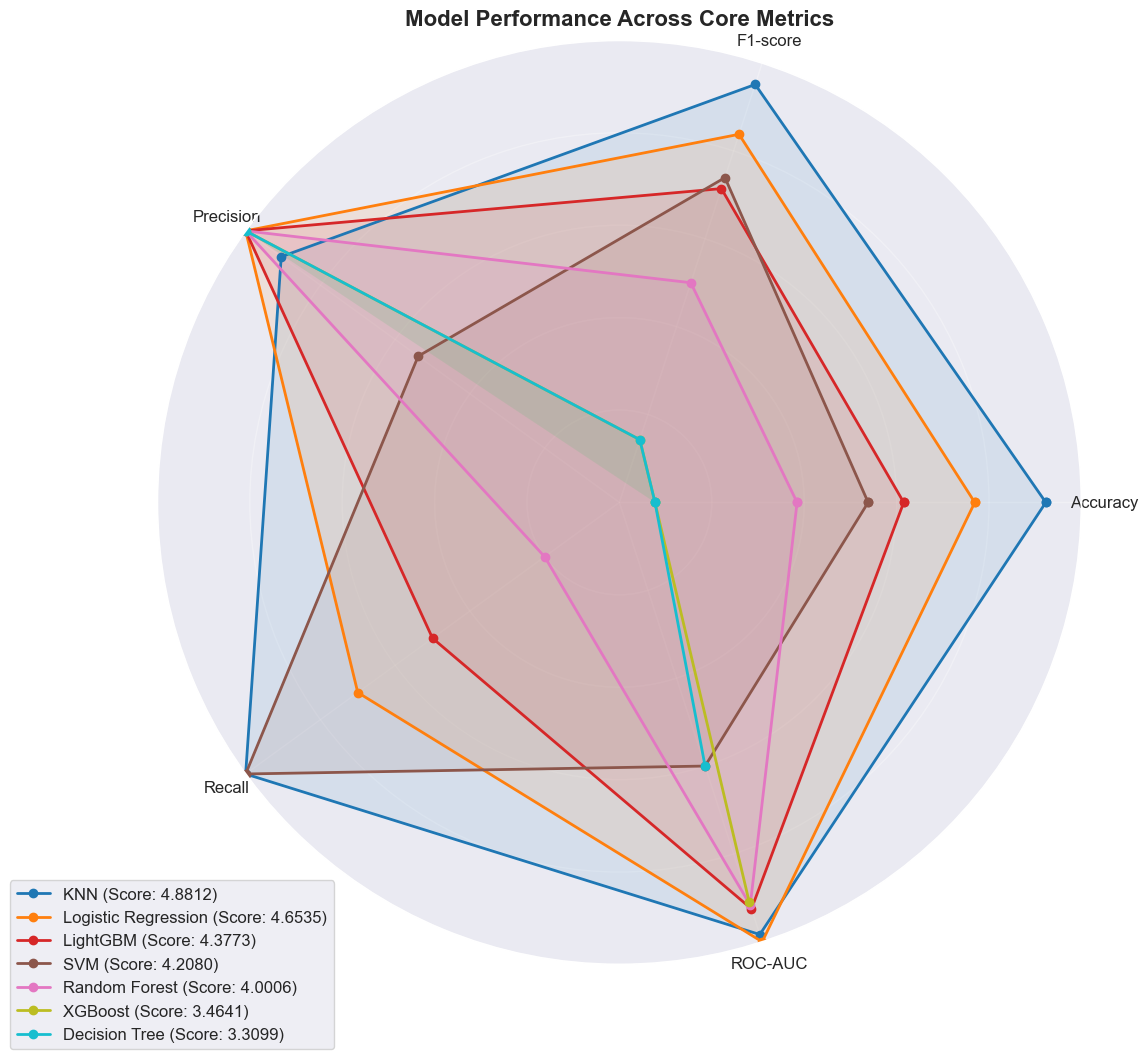


=== Individual Metric Comparisons ===


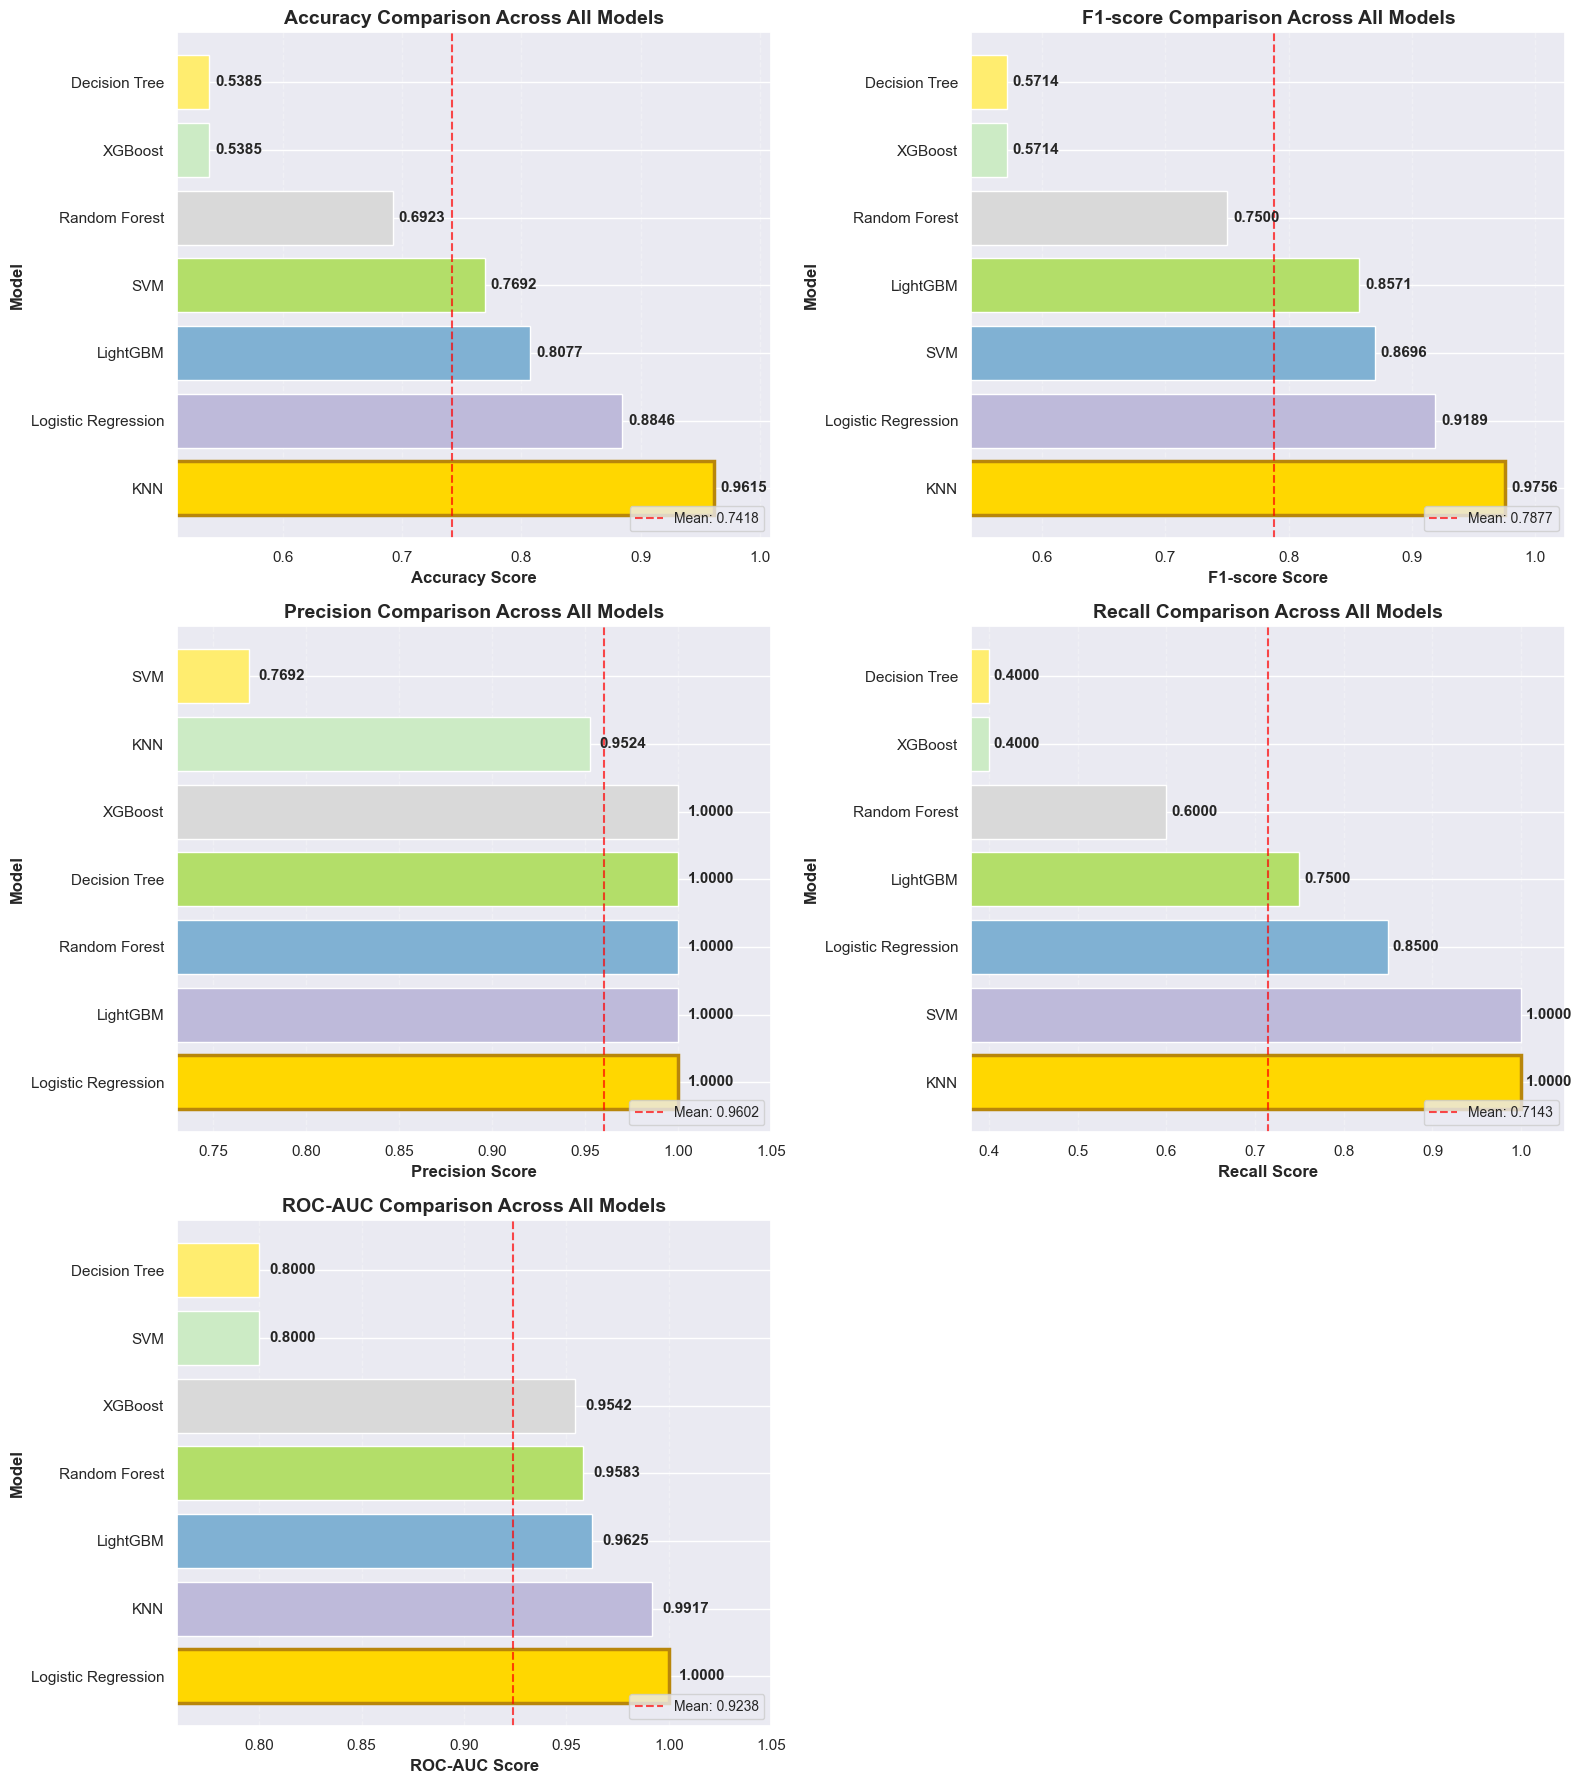


=== Grouped Metric Comparison ===


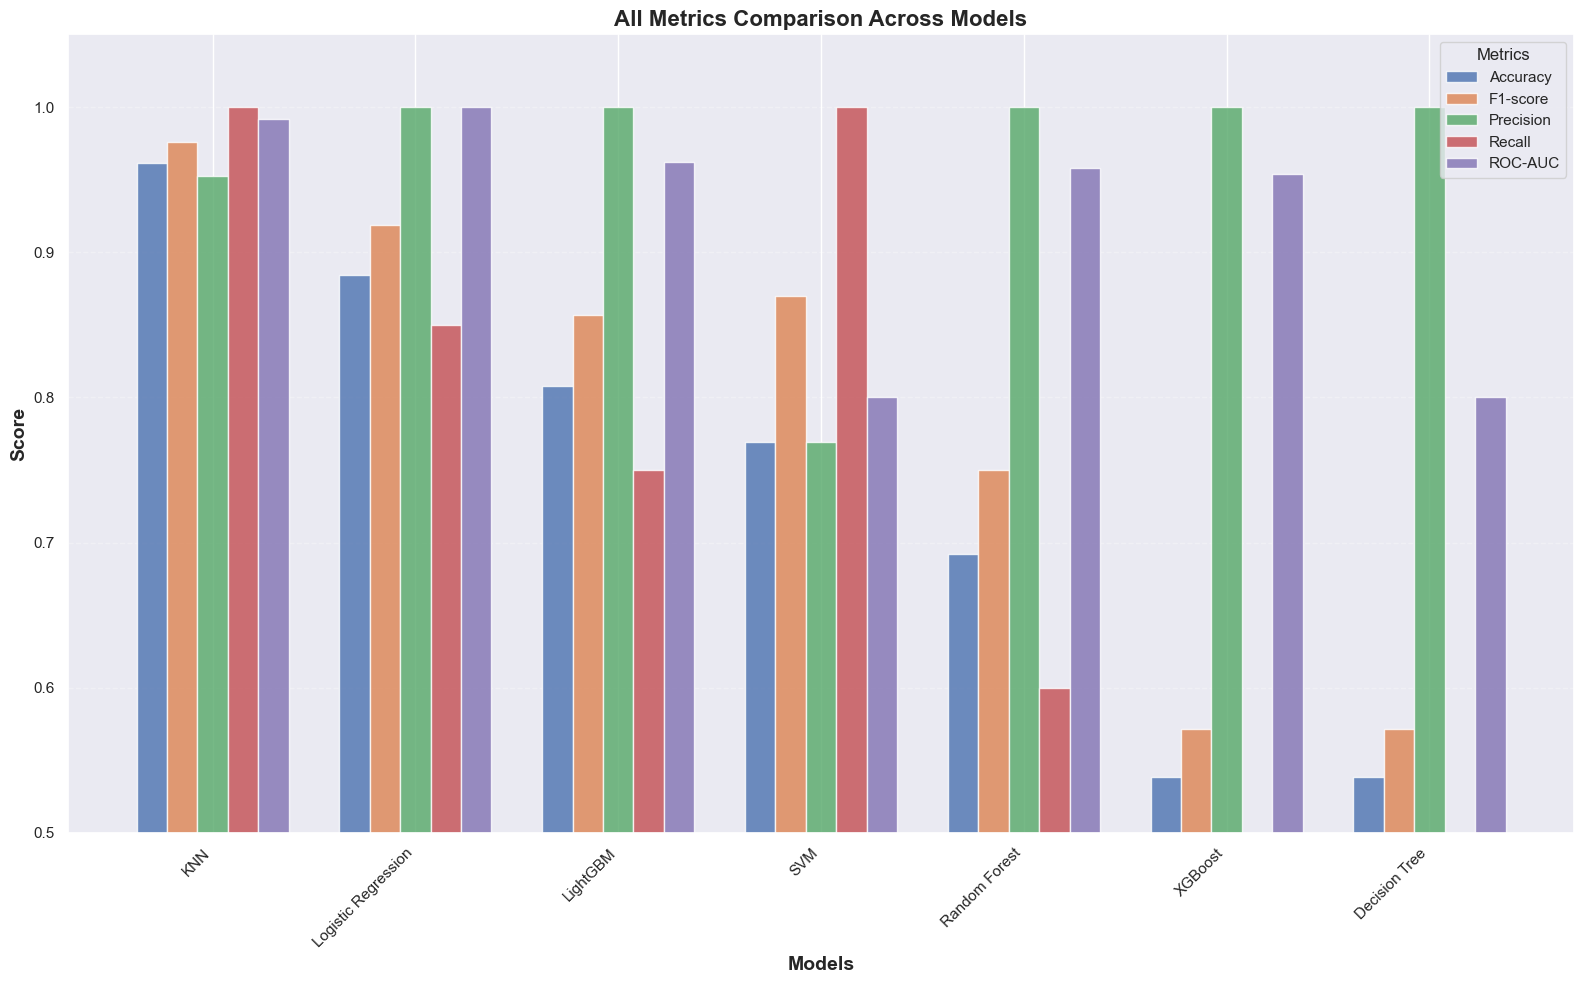

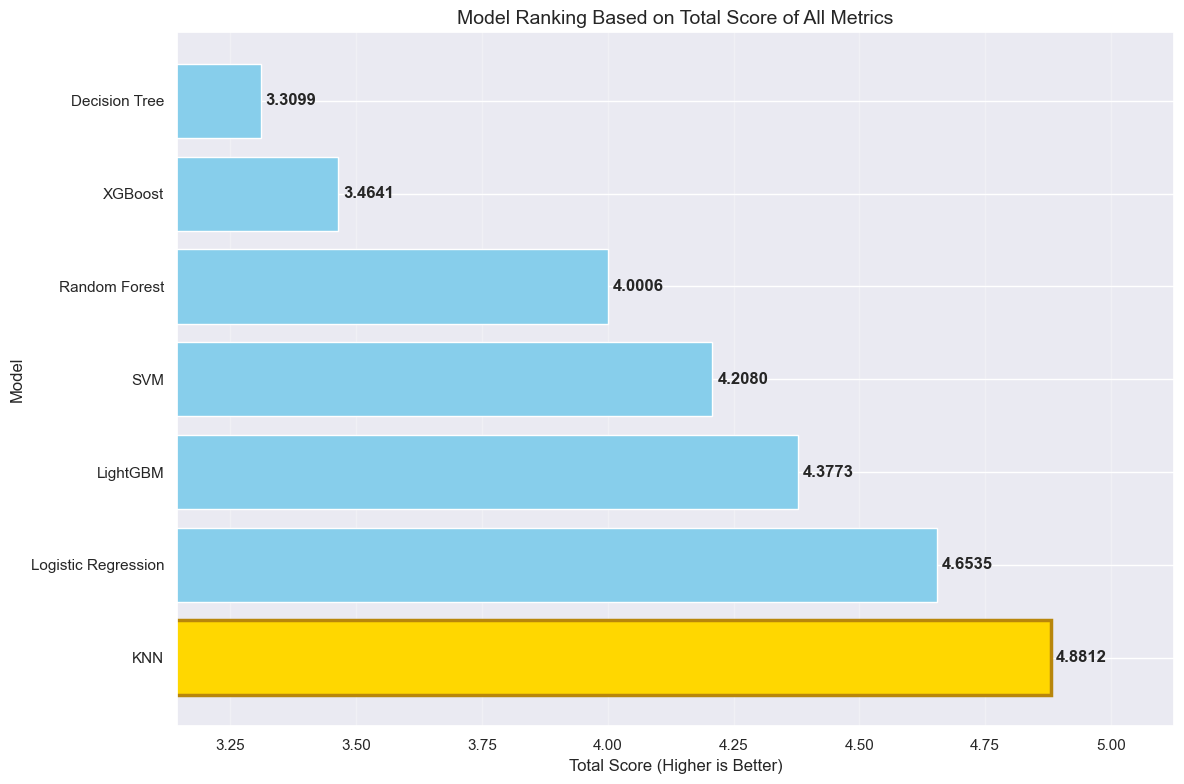

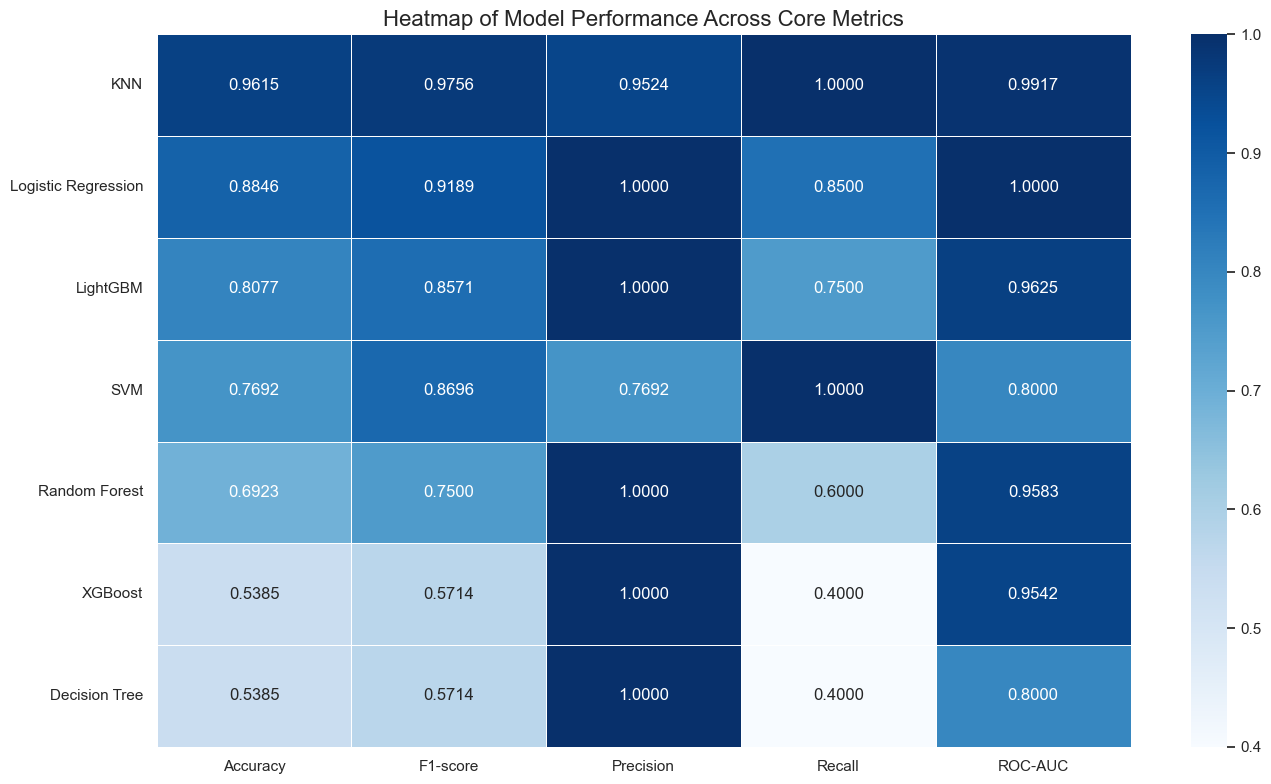

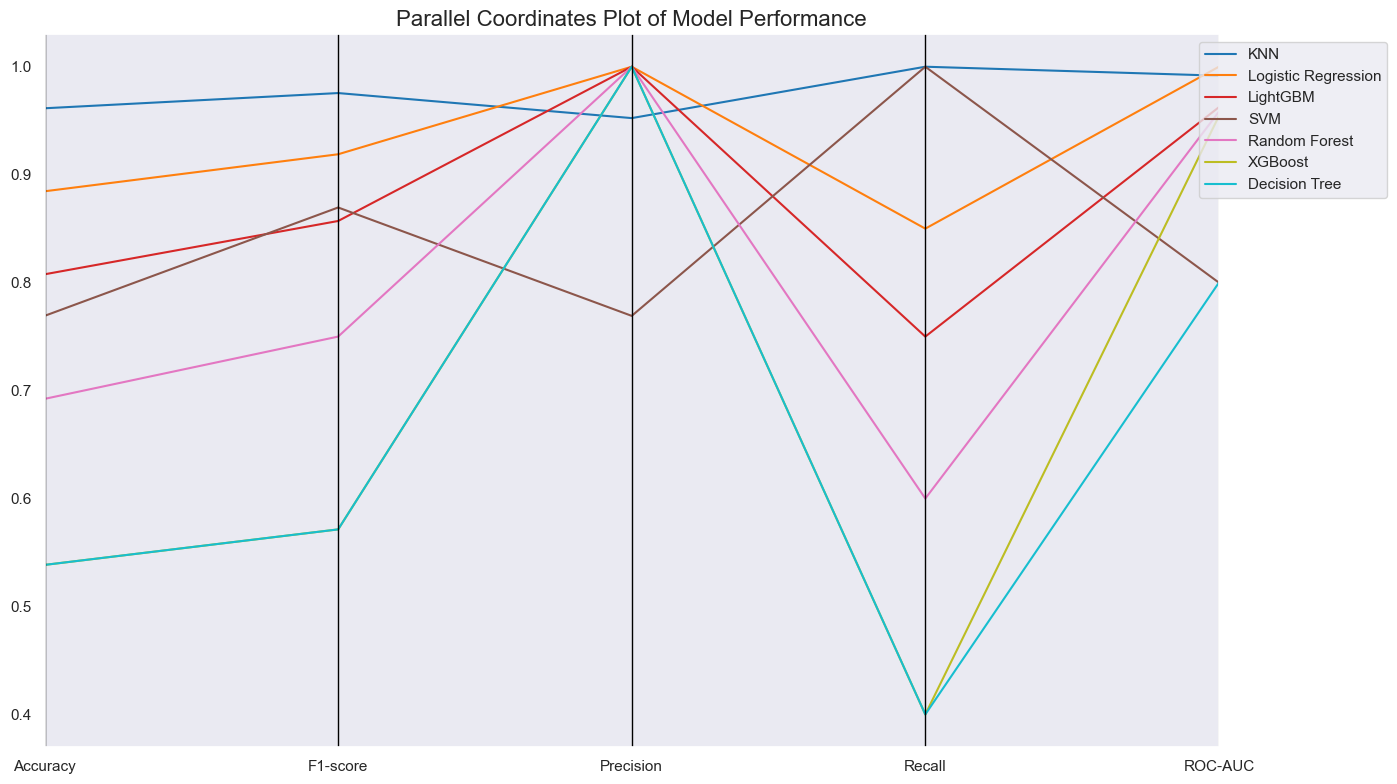


=== Best Overall Model: KNN ===
Total Score: 4.8812
Performance Metrics:
  - Accuracy: 0.9615
  - F1-score: 0.9756
  - Precision: 0.9524
  - Recall: 1.0000
  - ROC-AUC: 0.9917

Second Best Model: Logistic Regression
Total Score: 4.6535
Difference: 0.2277


In [26]:
# --- Create radar chart to visualize model performance across metrics ---
print("\n=== Performance Radar Chart (Higher is Better) ===")

# Use only core performance metrics for fair comparison
radar_metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall', 'ROC-AUC']
fig = plt.figure(figsize=(16, 12))

# Use all models 
all_model_names = summary_df_ranked['Model'].tolist()

# Define a colormap for better distinction between models
colors = plt.cm.tab10(np.linspace(0, 1, len(all_model_names)))

# Create radar chart with normalized metrics
for idx, model_name in enumerate(all_model_names):
    model_data = summary_df_ranked[summary_df_ranked['Model'] == model_name][radar_metrics].values[0]
    angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    # Add values (and close the loop)
    values = model_data.tolist()
    values += values[:1]
    
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, 'o-', linewidth=2, label=f"{model_name} (Score: {summary_df_ranked[summary_df_ranked['Model'] == model_name]['Total_Score'].values[0]:.4f})", color=colors[idx])
    ax.fill(angles, values, alpha=0.1, color=colors[idx])

# Set the angle labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics, fontsize=12)
ax.set_yticklabels([])  # Hide radial labels

# Draw y-axis circles
ax.set_rlabel_position(0)
ax.set_ylim(0.5, 1)  # Adjust range for better visualization
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0], color="grey", size=10)

# Position the legend for better visibility with all models
plt.legend(loc='upper right', bbox_to_anchor=(0.2, 0.1), fontsize=12)
plt.title("Model Performance Across Core Metrics", size=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# --- Individual Metric Comparison Plots ---
print("\n=== Individual Metric Comparisons ===")

# Define core metrics for individual plots
individual_metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall', 'ROC-AUC']

# Create a figure with subplots for each metric
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

# Color palette for consistent coloring
model_colors = plt.cm.Set3(np.linspace(0, 1, len(all_model_names)))

for idx, metric in enumerate(individual_metrics):
    ax = axes[idx]
    
    # Sort models by the current metric for better visualization
    metric_data = summary_df_ranked.sort_values(metric, ascending=False)
    
    # Create bar plot
    bars = ax.barh(metric_data['Model'], metric_data[metric], color=model_colors)
    
    # Highlight the best model for this metric
    best_idx = metric_data[metric].idxmax()
    bars[list(metric_data.index).index(best_idx)].set_color('gold')
    bars[list(metric_data.index).index(best_idx)].set_edgecolor('darkgoldenrod')
    bars[list(metric_data.index).index(best_idx)].set_linewidth(2.5)
    
    # Add value labels at the end of each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{width:.4f}', ha='left', va='center', fontsize=11, fontweight='bold')
    
    # Formatting
    ax.set_xlabel(f'{metric} Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Model', fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison Across All Models', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_xlim(min(metric_data[metric]) * 0.95, max(metric_data[metric]) * 1.05)
    
    # Add a vertical line at the mean value
    mean_val = metric_data[metric].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Mean: {mean_val:.4f}')
    ax.legend(loc='lower right', fontsize=10)

# Hide the extra subplot (we have 5 metrics, so 6th subplot is unused)
axes[5].axis('off')

plt.tight_layout()
plt.show()

# --- Create grouped bar chart comparing all metrics side by side ---
print("\n=== Grouped Metric Comparison ===")

fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data for grouped bar chart
x = np.arange(len(all_model_names))
width = 0.15  # Width of each bar

# Plot bars for each metric
for idx, metric in enumerate(individual_metrics):
    offset = width * (idx - len(individual_metrics)/2 + 0.5)
    metric_values = [summary_df_ranked[summary_df_ranked['Model'] == model][metric].values[0] 
                     for model in all_model_names]
    ax.bar(x + offset, metric_values, width, label=metric, alpha=0.8)

# Formatting
ax.set_xlabel('Models', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('All Metrics Comparison Across Models', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_model_names, rotation=45, ha='right', fontsize=11)
ax.legend(title='Metrics', fontsize=11, title_fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0.5, 1.05)

plt.tight_layout()
plt.show()

# Create a horizontal bar chart to clearly show total scores
plt.figure(figsize=(12, 8))
bars = plt.barh(summary_df_ranked['Model'], summary_df_ranked['Total_Score'], color='skyblue')
plt.xlabel('Total Score (Higher is Better)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Model Ranking Based on Total Score of All Metrics', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.xlim(min(summary_df_ranked['Total_Score']) * 0.95, max(summary_df_ranked['Total_Score']) * 1.05)

# Add score values at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontsize=12, fontweight='bold')

# Highlight the best model
bars[0].set_color('gold')
bars[0].set_edgecolor('darkgoldenrod')
bars[0].set_linewidth(2.5)

plt.tight_layout()
plt.show()

# Create heatmap of all metrics
plt.figure(figsize=(14, 8))
sns.heatmap(summary_df_ranked[radar_metrics], annot=True, cmap='Blues', 
            yticklabels=summary_df_ranked['Model'], fmt=".4f", linewidths=.5)
plt.title('Heatmap of Model Performance Across Core Metrics', size=16)
plt.tight_layout()
plt.show()

# Create a parallel coordinates plot for all metrics
from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates plot
parallel_data = summary_df_ranked.copy()
parallel_data['Model_Category'] = parallel_data['Model']  # Create category column

plt.figure(figsize=(14, 8))
parallel_coordinates(parallel_data, 'Model_Category', cols=radar_metrics, 
                     color=colors[:len(all_model_names)])
plt.title('Parallel Coordinates Plot of Model Performance', size=16)
plt.grid(False)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# Print best model summary
print(f"\n=== Best Overall Model: {best_model_name} ===")
print(f"Total Score: {summary_df_ranked.iloc[0]['Total_Score']:.4f}")
print(f"Performance Metrics:")
for metric in radar_metrics:
    print(f"  - {metric}: {summary_df_ranked.iloc[0][metric]:.4f}")
    
# Show comparison with second best
if len(summary_df_ranked) > 1:
    print(f"\nSecond Best Model: {summary_df_ranked.iloc[1]['Model']}")
    print(f"Total Score: {summary_df_ranked.iloc[1]['Total_Score']:.4f}")
    print(f"Difference: {summary_df_ranked.iloc[0]['Total_Score'] - summary_df_ranked.iloc[1]['Total_Score']:.4f}")

### 4. Saving the Best Model

Finally, let's save our best model and the scaler to disk for future use in production.

In [27]:
# Create directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save best model to pickle file
model_filename = os.path.join("models", f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved to: {model_filename}")

# Also save the scaler for future preprocessing
scaler_filename = os.path.join("models", "feature_scaler.pkl")
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

print(f"Feature scaler saved to: {scaler_filename}")

# Generate and save model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'hyperparameters': str(best_model.get_params()),  # Get current parameters from the model
    'performance': {
        'accuracy': float(summary_df_ranked.iloc[0]['Accuracy']),
        'f1_score': float(summary_df_ranked.iloc[0]['F1-score']),
        'precision': float(summary_df_ranked.iloc[0]['Precision']), 
        'recall': float(summary_df_ranked.iloc[0]['Recall']),
        'roc_auc': float(summary_df_ranked.iloc[0]['ROC-AUC'])
    },
    'features': list(X_train.columns),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d')
}

# Save metadata
metadata_filename = os.path.join("models", "model_metadata.pkl")
with open(metadata_filename, 'wb') as file:
    pickle.dump(metadata, file)

print(f"Model metadata saved to: {metadata_filename}")

Best model saved to: models\best_model_knn.pkl
Feature scaler saved to: models\feature_scaler.pkl
Model metadata saved to: models\model_metadata.pkl


### Ensemble Approach:
All seven trained models (Logistic Regression, KNN, Random Forest, Decision Tree, SVM, LightGBM, XGBoost) were combined using a soft voting classifier to leverage their collective strengths and improve overall prediction performance.

This ensemble approach combines:
- **Linear Model**: Logistic Regression - captures linear relationships
- **Instance-based**: KNN - leverages similarity patterns
- **Tree Ensembles**: Random Forest - handles non-linear patterns and feature interactions
- **Single Tree**: Decision Tree - provides interpretable decision rules
- **Support Vector**: SVM - finds optimal decision boundaries
- **Gradient Boosting**: LightGBM & XGBoost - sequential learning with regularization

The soft voting method aggregates predicted probabilities from all models, often improving overall accuracy, reducing variance, and creating a more robust and stable prediction system by reducing the impact of any single model's errors.

In [28]:
# --- Ensemble with all 7 trained models ---
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Define the ensemble with ALL trained models
ensemble_model = VotingClassifier(
    estimators=[
        ('logistic_regression', lr_model),
        ('knn', knn_model),
        ('random_forest', rf_model),
        ('decision_tree', dt_model),
        ('svm', svm_model),
        ('lightgbm', lgb_model),
        ('xgboost', xgb_model)
    ],
    voting='soft'  # uses predicted probabilities
)

print("=== Training Ensemble Model ===")
print(f"Ensemble includes {len(ensemble_model.estimators)} models:")
for name, _ in ensemble_model.estimators:
    print(f"  - {name}")

# Train the ensemble
ensemble_model.fit(X_train_scaled, y_train)
print("\n✓ Ensemble training completed!")

# Make predictions
y_pred = ensemble_model.predict(X_test_scaled)
y_proba = ensemble_model.predict_proba(X_test_scaled)[:,1]

# --- Evaluation Metrics ---
accuracy = round(accuracy_score(y_test, y_pred), 4)
f1 = round(f1_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred), 4)
recall = round(recall_score(y_test, y_pred), 4)
roc_auc = round(roc_auc_score(y_test, y_proba), 4)
cm = confusion_matrix(y_test, y_pred)

# Print results
print("\n" + "="*70)
print("=== Ensemble Model Performance (All 7 Models) ===")
print("="*70)
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


=== Training Ensemble Model ===
Ensemble includes 7 models:
  - logistic_regression
  - knn
  - random_forest
  - decision_tree
  - svm
  - lightgbm
  - xgboost

✓ Ensemble training completed!

=== Ensemble Model Performance (All 7 Models) ===
Accuracy:  0.9615
F1-Score:  0.9756
Precision: 0.9524
Recall:    1.0000
ROC-AUC:   1.0000

Confusion Matrix:
[[ 5  1]
 [ 0 20]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091         6
           1     0.9524    1.0000    0.9756        20

    accuracy                         0.9615        26
   macro avg     0.9762    0.9167    0.9424        26
weighted avg     0.9634    0.9615    0.9603        26



#### Placing the ensemble model into a new file

In [29]:
# --- Save the Ensemble Model for Deployment ---
# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Define the deployment model (ensemble)
deployment_model = ensemble_model

# Save the ensemble model
ensemble_filename = os.path.join("models", "ensemble_model.pkl")
joblib.dump(deployment_model, ensemble_filename)
print(f"✓ Ensemble model saved to: {ensemble_filename}")

# Save ensemble metadata
ensemble_metadata = {
    'model_name': 'Ensemble Voting Classifier',
    'model_type': 'VotingClassifier',
    'ensemble_models': [name for name, _ in ensemble_model.estimators],
    'voting_type': 'soft',
    'num_models': len(ensemble_model.estimators),
    'performance': {
        'accuracy': float(accuracy),
        'f1_score': float(f1),
        'precision': float(precision),
        'recall': float(recall),
        'roc_auc': float(roc_auc)
    },
    'features': list(X_train.columns),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save ensemble metadata
ensemble_metadata_filename = os.path.join("models", "ensemble_metadata.pkl")
with open(ensemble_metadata_filename, 'wb') as file:
    pickle.dump(ensemble_metadata, file)
print(f"✓ Ensemble metadata saved to: {ensemble_metadata_filename}")

# Also save to root for backward compatibility
joblib.dump(deployment_model, 'bankruptcy_ensemble_model.pkl')
print(f"✓ Ensemble model also saved to: bankruptcy_ensemble_model.pkl")

print("\n" + "="*70)
print("=== Deployment Files Ready ===")
print("="*70)
print(f"Main Model:     {ensemble_filename}")
print(f"Metadata:       {ensemble_metadata_filename}")
print(f"Scaler:         {scaler_filename}")
print(f"Model Count:    {len(ensemble_model.estimators)} models")
print(f"Voting Type:    {ensemble_model.voting}")
print(f"Performance:    Accuracy={accuracy:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}")
print("\n✓ All files saved successfully!")

# --- Example: Load and use the model later ---
# loaded_model = joblib.load('models/ensemble_model.pkl')
# loaded_scaler = joblib.load('models/feature_scaler.pkl')
# predictions = loaded_model.predict(loaded_scaler.transform(new_data))

✓ Ensemble model saved to: models\ensemble_model.pkl
✓ Ensemble metadata saved to: models\ensemble_metadata.pkl
✓ Ensemble model also saved to: bankruptcy_ensemble_model.pkl

=== Deployment Files Ready ===
Main Model:     models\ensemble_model.pkl
Metadata:       models\ensemble_metadata.pkl
Scaler:         models\feature_scaler.pkl
Model Count:    7 models
Voting Type:    soft
Performance:    Accuracy=0.9615, F1=0.9756, ROC-AUC=1.0000

✓ All files saved successfully!
